# Aleatoric and Epistemic Uncertainty and BNNs
* Aleatoric uncertainty captures noise inherent in the observations (data).
* Epistemic uncertainty accounts for uncertainty in the model.

In general there are a couple of different techniques involved with BNNs that can be represented by the output layers of the BNNs:
* Deterministic -- Often using a DenseFlipout or DenseVariational layer (as in Tensorflow) which will learn a distribution of weights but give a single determinstic solution. For UQ you would need to create many different samples over the model to get a distribution of outputs.
* Probabilistic -- Often using a DistributionLambda layer (as in TensorFlow) which will learn the full distribution of the prediction and when evaluated will yield the full PDF. For UQ, you could evaluate the statistics of the PDF that is output. For predictions, you would typically take the mean or most likely value from the PDF.

### Epistemic Uncertainty (model uncertainty)
Arises from the lack of knowledge. Uncertainty that can be reduced given more data. In the context of Bayesian neural networks, epistemic uncertainty is often quantified by looking at the variability in the predictions made by the ensemble of models.

### Aleatoric Uncertainty (data uncertainty)
Arised from the inherent noise in the data. Uncertainty that cannot be reduced even with more data. In the context of Bayesian neural networks, aleatoric uncertainty is often quantified by looking at the output distribution for each individual prediction.


## Standard Artificial Neural Network (ANN)
Here is how one could quantify the different types of uncertainty using a standard Artificial Neural Network (ANN):
* Aleatoric -- The ANN can be modified to predict the variance along with the prediction. The final layer would need to have twice as many outputs as required by the target values. A custom loss function would also be required to encourage the network to predict the correct variance.
* Epistemic -- Monte Carlo dropout: applying dropout during both training and prediction and running the model multiple times. Bootstrapping: training multiple modesl on different subsets of the data.

## Full Bayesian Neural Network (BNN)
Here is how one could quantify the different types of uncertainty using a full Bayesian Neural Network (BNN):
* Aleatoric -- Add a DistributionLambda layer as the final layer, which outputs a distribution for each prediction.
* Epistemic -- Use a DenseFlipout (or similar) layer as the final layer, which outputs a single value for each prediction. Generte an ensemble of predictions by running the model multiple times (weights in all layers are sampled from a distribution).

## Bayesian Last Layer (BLL)
Here is how one could quantify the different types of uncertainty using a Bayesian Last Layer (BLL):
* Aleatoric -- Use a DistributionLambda layer which directly models the aleatoric uncertainty.
* Epistemic -- Techniques like Monte Carlo Dropout can be used to estimate the epistemic uncertainty. Here, dropout is applied during both training and prediction which effectively creates an ensemble of different models with shared weights.

---
# Notebook Outline
In this notebook, we will go through all of the variations of Bayesian NNs on a toy test set using a full BNN and a BLL to model the epistemic and Aleatoric uncertainties associated with a multivariate dataset with varying amounts of noise.

In [1]:
# Import the sklearn datasets
import sklearn.datasets as sdt
import numpy as np
import matplotlib.pyplot as plt

# Create a non-linear distribution using the sklearn make_regression function
n_samples = 1000
n_feats = 10
n_info = 5
n_targets = 3
noise = 10

x, y = sdt.make_regression(n_samples=n_samples, n_features=n_feats, n_informative=n_info, n_targets=n_targets, noise=noise, random_state=42)

print(f"Shape of x: {x.shape}", f"Shape of y: {y.shape}")


Shape of x: (1000, 10) Shape of y: (1000, 3)


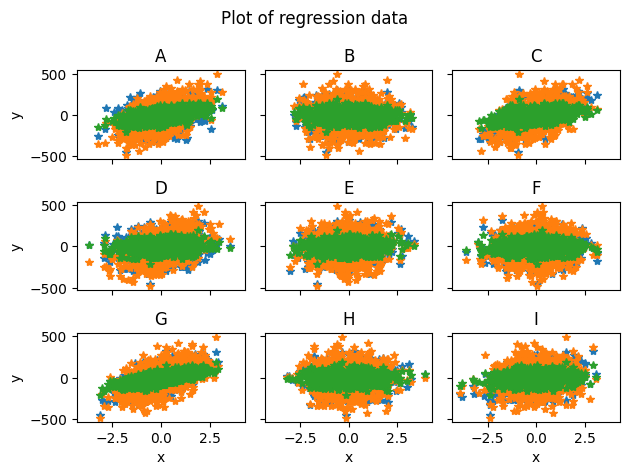

In [2]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x[:,idx], y, marker="*", linestyle="None")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle("Plot of regression data")
fig.tight_layout()
plt.show()

In [3]:
# Use sklearn scaling libraries so we can iterate on data scaling methods easier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split

# norm_type = "minmax"
# norm_type = "standard"
norm_type = "robust"
# norm_type = "power"
# norm_type = "quantile"

if norm_type == "standard":
    x_normalizer = StandardScaler()
    y_normalizer = StandardScaler()
elif norm_type == "minmax":
    feature_range = (0, 1)
    x_normalizer = MinMaxScaler(feature_range=feature_range)
    y_normalizer = MinMaxScaler(feature_range=feature_range)
elif norm_type == "robust":
    quantile_range = (25, 75)
    x_normalizer = RobustScaler(quantile_range=quantile_range)
    y_normalizer = RobustScaler(quantile_range=quantile_range)
elif norm_type == "power":
    x_normalizer = PowerTransformer()
    y_normalizer = PowerTransformer()
elif norm_type == "quantile":
    dist_type = 'normal'
    x_normalizer = QuantileTransformer(output_distribution=dist_type)
    y_normalizer = QuantileTransformer(output_distribution=dist_type)


x_normalizer.fit(x)
y_normalizer.fit(y)

x_norm = x_normalizer.transform(x)
y_norm = y_normalizer.transform(y)

# Create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)


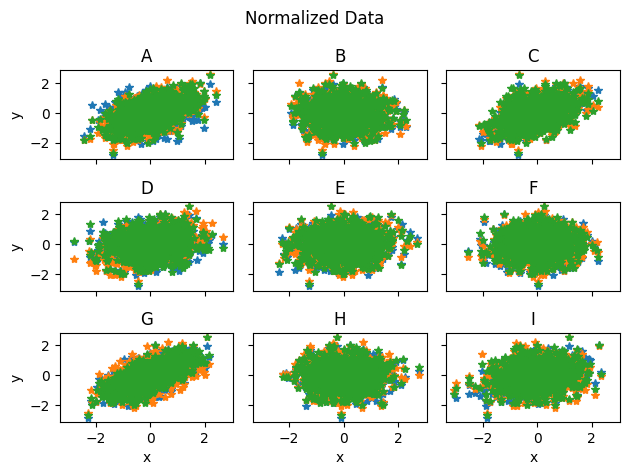

In [4]:
# Visualize the data using a mosaic plot
mosaic = [['A', 'B', 'C'],
          ['D', 'E', 'F'],
          ['G', 'H', 'I']]
fig, axdict = plt.subplot_mosaic(mosaic, sharex=True, sharey=True)
# Loop over all the labels in the mosaic
for idx, ilabel in enumerate(axdict.keys()):
    axdict[ilabel].plot(x_norm[:,idx], y_norm, marker="*", linestyle="None")
    # Set some plot labels
    axdict[ilabel].set_title(ilabel)
    if ilabel in ['A', 'D', 'G']:
        axdict[ilabel].set_ylabel("y")
    if ilabel in ['G', 'H', 'I']:
        axdict[ilabel].set_xlabel("x")

fig.suptitle('Normalized Data')
fig.tight_layout()
plt.show()

<hr style="border:50px solid white"> </hr>

# Artificial Neural Network (ANN)
Train a standard feed-forward ANN as a benchmark.

In [5]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2

# Create a simple neural network model
width = 10
l1_norm = 1e-3
l2_norm = 1e-3
learning_rate = 1e-3
loss = "mse"

# Create an ANN class
class ANN(Model):
    def __init__(self, width, l1_norm, l2_norm, n_targets):
        """
        Initializes the ANN model.

        Args:
            width (int): The width of the dense layers.
            l1_norm (float): The L1 regularization parameter.
            l2_norm (float): The L2 regularization parameter.
        """
        super(ANN, self).__init__()

        self.width = width
        self.l1_norm = l1_norm
        self.l2_norm = l2_norm
        self.n_targets = n_targets

        self.dense1 = Dense(width, activation='relu', kernel_regularizer=L1L2(l1=l1_norm, l2=l2_norm))
        self.dense2 = Dense(width, activation='relu', kernel_regularizer=L1L2(l1=l1_norm, l2=l2_norm))
        self.dense3 = Dense(width, activation='relu', kernel_regularizer=L1L2(l1=l1_norm, l2=l2_norm))
        self.output_layer = Dense(n_targets, activation='linear')

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.output_layer(x)
    

# Compile the model
model = ANN(width=width, l1_norm=l1_norm, l2_norm=l2_norm, n_targets=n_targets)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss)

# Print the model summary
model.build(input_shape=(n_samples, n_feats))
model.summary()

2024-02-20 16:53:32.360540: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "ann"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  110       
                                                                 
 dense_1 (Dense)             multiple                  110       
                                                                 
 dense_2 (Dense)             multiple                  110       
                                                                 
 dense_3 (Dense)             multiple                  33        
                                                                 
Total params: 363
Trainable params: 363
Non-trainable params: 0
_________________________________________________________________


2024-02-20 16:53:33.839008: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1182 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:03:00.0, compute capability: 8.6
2024-02-20 16:53:33.839626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5178 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:09:00.0, compute capability: 8.6


In [6]:
# Train the model
batch_size = 32
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=1000,
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/1000


2024-02-20 16:53:47.755975: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-02-20 16:53:47.765785: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f00c903f0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-20 16:53:47.765802: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-20 16:53:47.765807: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (1): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-20 16:53:47.769689: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-20 16:53:47.785423: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-02-20 

25/25 [==============================] - 1s 6ms/step - loss: 0.6700 - val_loss: 0.8473
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.6200 - val_loss: 0.8125
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5949 - val_loss: 0.7891
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5721 - val_loss: 0.7568
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.5427 - val_loss: 0.7156
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4968 - val_loss: 0.6474
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4272 - val_loss: 0.5432
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3369 - val_loss: 0.4105
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2489 - val_loss: 0.2853
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.1868 - val_loss: 0.2047
Epoch 11/100

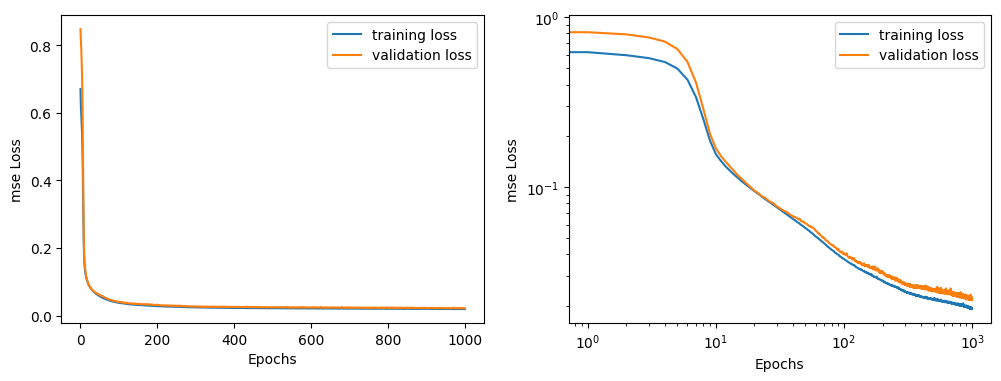

In [7]:
# Plot the loss function over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history["loss"], label="training loss")
ax1.plot(history.history["val_loss"], label="validation loss")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel(f"{loss} Loss")

ax2.loglog(history.history["loss"], label="training loss")
ax2.loglog(history.history["val_loss"], label="validation loss")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel(f"{loss} Loss")
plt.show()

In [8]:
# Evaluate the model performance on train and validation data
pred_norm = model(x_norm, training=False)
pred_norm_train = model(x_train, training=False)
pred_norm_val = model(x_val, training=False)
pred_norm_test = model(x_test, training=False)

# Unscale the results and plot
pred_full = y_normalizer.inverse_transform(pred_norm)
pred_train = y_normalizer.inverse_transform(pred_norm_train)
pred_val = y_normalizer.inverse_transform(pred_norm_val)
pred_test = y_normalizer.inverse_transform(pred_norm_test)

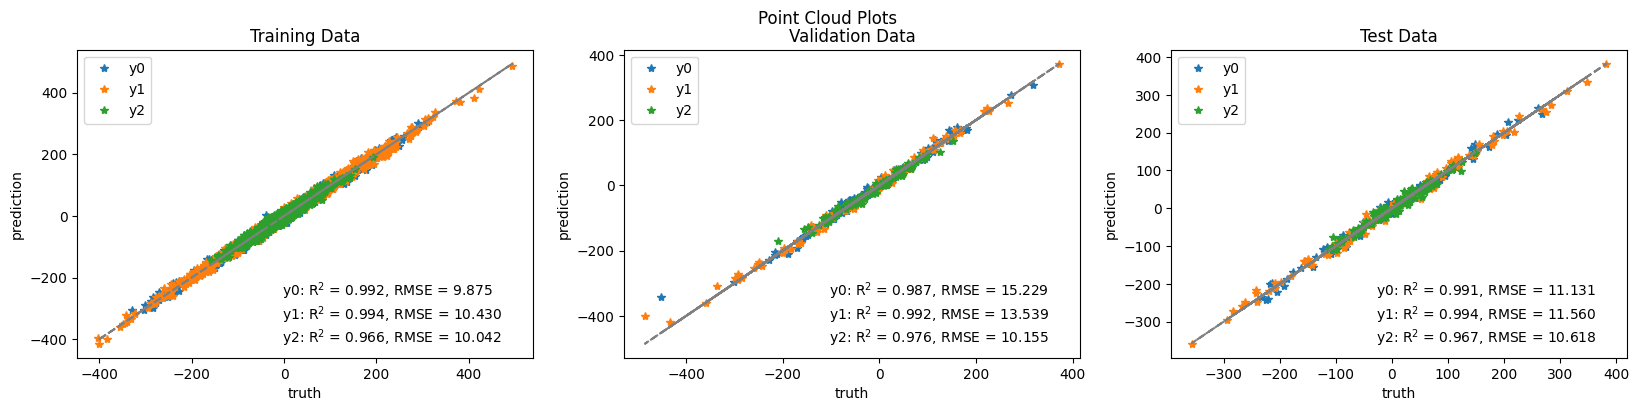

In [10]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/(truth+1e-6))**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
# Train plot
for i in range(n_targets):
    ax1.plot(y_train_real[:, i], pred_train[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    # ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
    ax1.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    # Validation plot
    ax2.plot(y_val_real[:, i], pred_val[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    # Test plot
    ax3.plot(y_test_real[:, i], pred_test[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")

fig.suptitle('Point Cloud Plots')
plt.show()

## Estimating Epistemic Uncertainty using ANNs
Here, we will use Monte Carlo Dropout to estimate the epistemic uncertainty of the ANN model.

To do so, we will modify the above ANN model to have dropout layers and then after training, we will sample the network with dropout layer activated.

In [11]:
# Create a new model class with dropout based on the previous model
from tensorflow.keras.layers import Dropout
class DropoutANN(ANN):
    """
    A subclass of ANN that implements dropout regularization.

    Parameters:
    - width (int): The width of the hidden layers.
    - l1_norm (float): The L1 regularization parameter.
    - l2_norm (float): The L2 regularization parameter.
    - dropout_rate (float): The dropout rate.

    Attributes:
    - dropout1 (Dropout): The dropout layer for the first hidden layer.
    - dropout2 (Dropout): The dropout layer for the second hidden layer.
    - dropout3 (Dropout): The dropout layer for the third hidden layer.
    """

    def __init__(self, width, l1_norm, l2_norm, dropout_rate, n_targets):
        super(DropoutANN, self).__init__(width, l1_norm, l2_norm, n_targets)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        self.dropout3 = Dropout(dropout_rate)

    def call(self, x, training=False):
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        x = self.dropout2(x, training=training)
        x = self.dense3(x)
        x = self.dropout3(x, training=training)
        return self.output_layer(x)
    

# Compile the model
width = 20
dropout_rate = 0.2
l1_norm = 1e-8
l2_norm = 1e-8
learning_rate = 1e-3
loss = "mse"

model_dropout = DropoutANN(width=width, l1_norm=l1_norm, l2_norm=l2_norm, dropout_rate=dropout_rate, n_targets=n_targets)
model_dropout.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss)

# Print the model summary
model_dropout.build(input_shape=(n_samples, n_feats))
model_dropout.summary()

Model: "dropout_ann"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             multiple                  220       
                                                                 
 dense_5 (Dense)             multiple                  420       
                                                                 
 dense_6 (Dense)             multiple                  420       
                                                                 
 dense_7 (Dense)             multiple                  63        
                                                                 
 dropout (Dropout)           multiple                  0         
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 dropout_2 (Dropout)         multiple                  

In [12]:
# Train the model
batch_size = 32
history = model_dropout.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=1000,
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/1000


25/25 [==============================] - 1s 6ms/step - loss: 0.5749 - val_loss: 0.6885
Epoch 2/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4978 - val_loss: 0.6193
Epoch 3/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4555 - val_loss: 0.5549
Epoch 4/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.4086 - val_loss: 0.4818
Epoch 5/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3590 - val_loss: 0.3986
Epoch 6/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.3009 - val_loss: 0.3175
Epoch 7/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2743 - val_loss: 0.2534
Epoch 8/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2458 - val_loss: 0.2122
Epoch 9/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2315 - val_loss: 0.1947
Epoch 10/1000
25/25 [==============================] - 0s 2ms/step - loss: 0.2027 - val_loss: 0.1690
Epoch 11/100

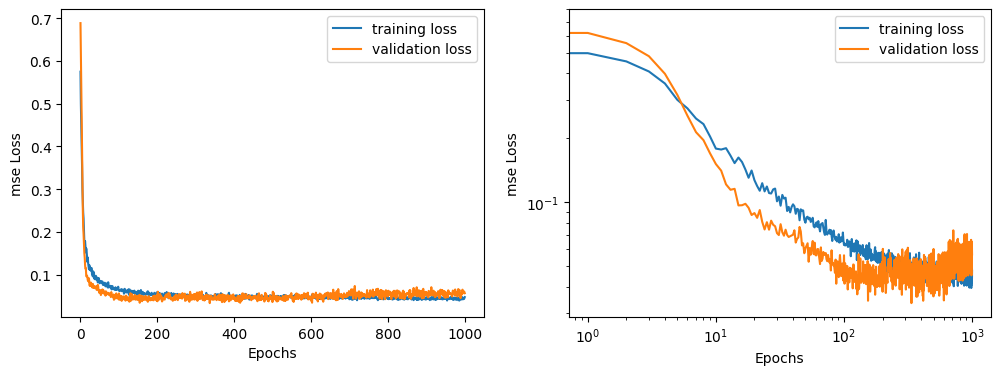

In [13]:
# Plot the loss function over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history["loss"], label="training loss")
ax1.plot(history.history["val_loss"], label="validation loss")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel(f"{loss} Loss")

ax2.loglog(history.history["loss"], label="training loss")
ax2.loglog(history.history["val_loss"], label="validation loss")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel(f"{loss} Loss")
plt.show()

 When it comes to evaluating the performance of the model, this is where things are slightly different than normal. We can evaluate the model in the following ways:
 * Inference mode (training=False) -- for deterministic predictions.
 * Training mode (training=True) -- for epistemic uncertainty quantification after performing an ensemble of predictions.

### Inference mode
Running in inference mode (training=False) will disable the dropout layers.

In [14]:
# Evaluate the model performance on train and validation data
pred_norm = model_dropout(x_norm, training=False)
pred_norm_train = model_dropout(x_train, training=False)
pred_norm_val = model_dropout(x_val, training=False)
pred_norm_test = model_dropout(x_test, training=False)

# Unscale the results and plot
pred_full = y_normalizer.inverse_transform(pred_norm)
pred_train = y_normalizer.inverse_transform(pred_norm_train)
pred_val = y_normalizer.inverse_transform(pred_norm_val)
pred_test = y_normalizer.inverse_transform(pred_norm_test)

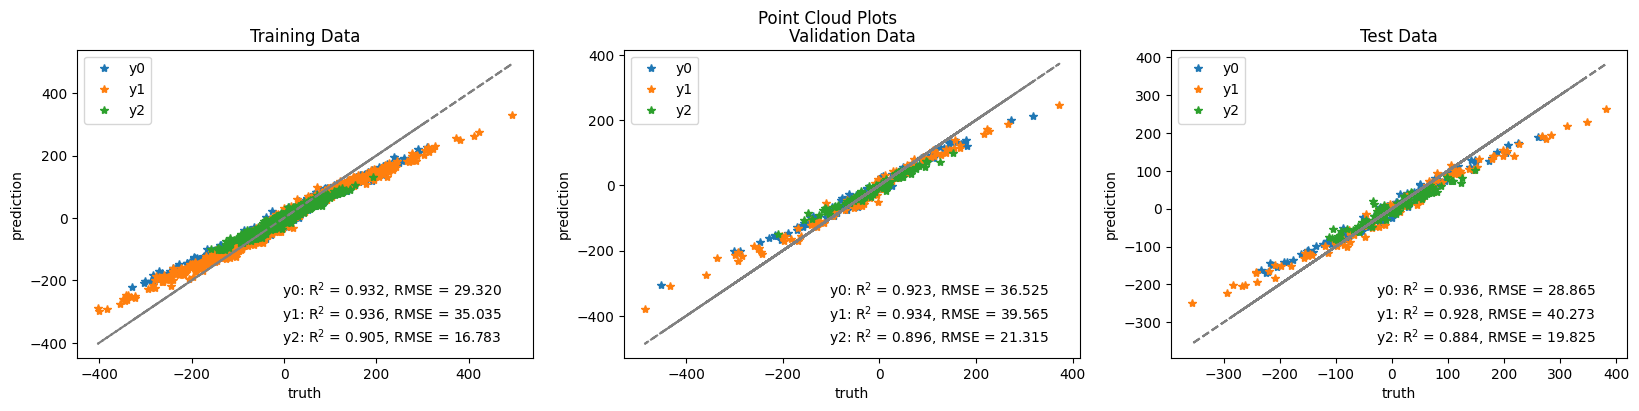

In [15]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/(truth+1e-6))**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
# Train plot
for i in range(n_targets):
    ax1.plot(y_train_real[:, i], pred_train[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    # ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
    ax1.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    # Validation plot
    ax2.plot(y_val_real[:, i], pred_val[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    # Test plot
    ax3.plot(y_test_real[:, i], pred_test[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")

fig.suptitle('Point Cloud Plots')
plt.show()

### Epistemic Uncertainty Quantification
Now let's modify the evaluation code to get an estimate of the aleatoric uncertainty. Here, we will create an ensemble of predictions with the dropout layers enabled (training=True).

In [16]:
# Evaluate the model performance on train and validation data using an ensemble of predictions with dropout enabled
num_preds = 100
pred_norm = np.stack([model_dropout(x_norm, training=True) for _ in range(num_preds)], axis=0)
pred_norm_train = np.stack([model_dropout(x_train, training=True) for _ in range(num_preds)], axis=0)
pred_norm_val = np.stack([model_dropout(x_val, training=True) for _ in range(num_preds)], axis=0)
pred_norm_test = np.stack([model_dropout(x_test, training=True) for _ in range(num_preds)], axis=0)

# First, unscale the results of the ensemble before computing the statistics
pred_full = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm], axis=0)
pred_train = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_train], axis=0)
pred_val = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_val], axis=0)
pred_test = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_test], axis=0)

# Compute the mean and standard deviation of the predictions
pred_mean = np.mean(pred_full, axis=0)
pred_std = np.std(pred_full, axis=0)
pred_mean_train = np.mean(pred_train, axis=0)
pred_std_train = np.std(pred_train, axis=0)
pred_mean_val = np.mean(pred_val, axis=0)
pred_std_val = np.std(pred_val, axis=0)
pred_mean_test = np.mean(pred_test, axis=0)
pred_std_test = np.std(pred_test, axis=0)

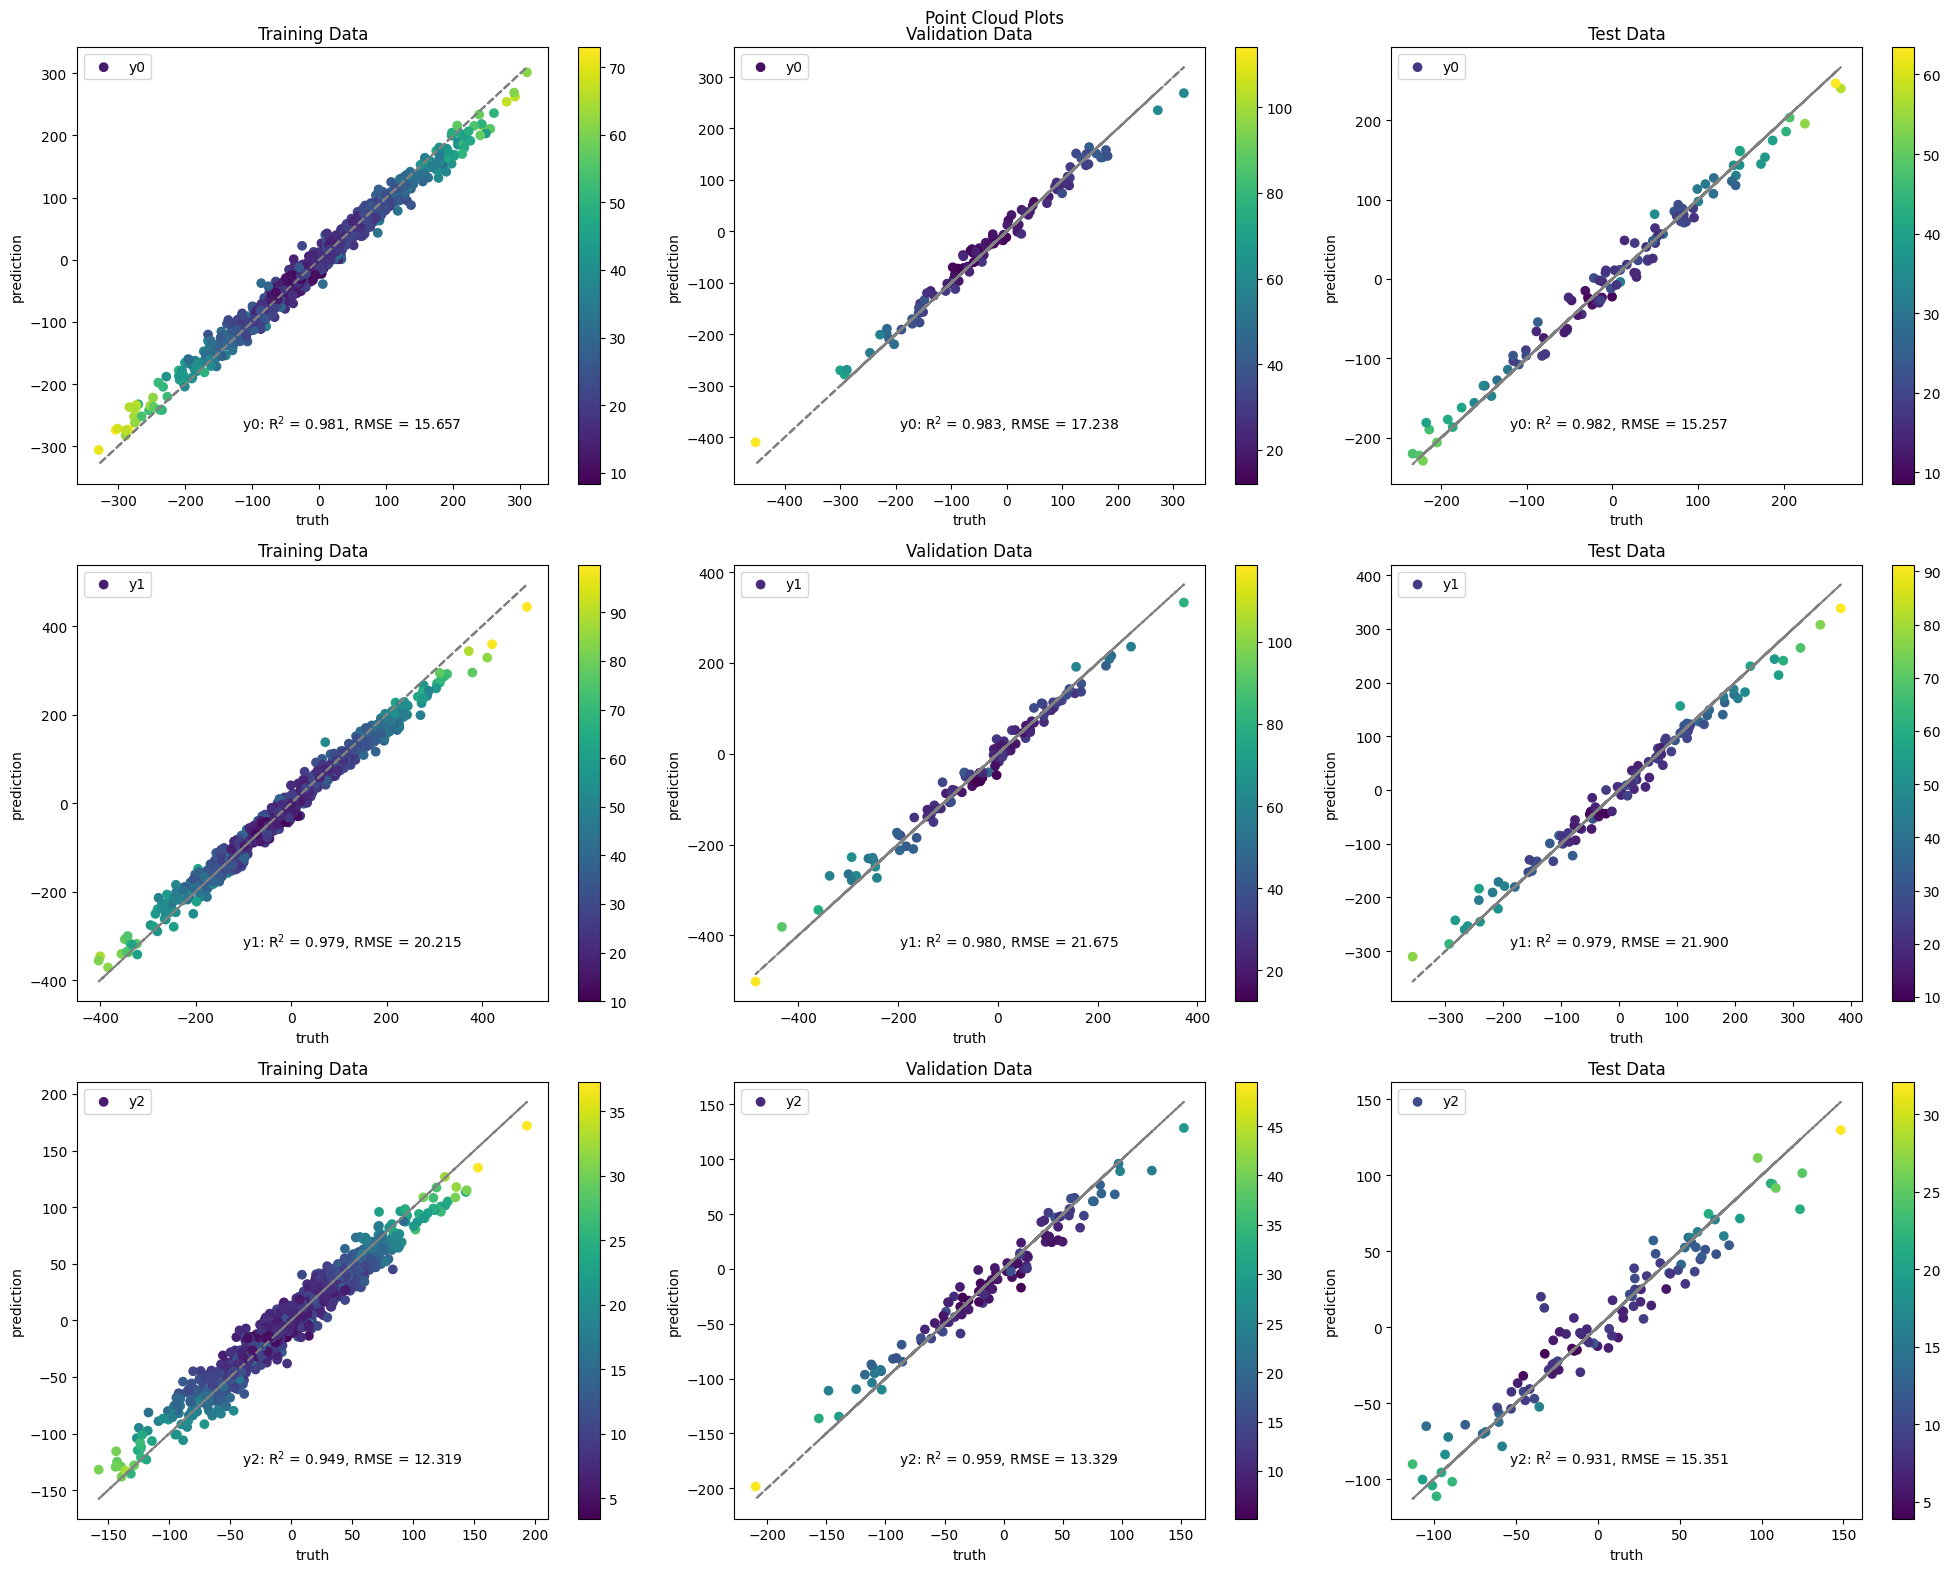

In [17]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/truth)**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_mean_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_mean_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_mean_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    # ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
    ax1.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Point Cloud Plots')
fig.tight_layout()
plt.show()

## Estimatic Aleatoric Uncertainty using ANNs
Now, we will try using ANNs to estimate the aleatoric uncertainty contained in the data by having the ANN output the mean and variance of the predictions and by modifying the loss function accordingly.

In [38]:
# Creata a new model class for aleatoric uncertainty quanitfication inheriting from the ANN class
import tensorflow as tf

class AleatoricANN(ANN):
    """
    A subclass of ANN that implements aleatoric uncertainty quantification.
    
    Attributes:
        width (int): The width of the neural network.
        l1_norm (float): The L1 regularization parameter.
        l2_norm (float): The L2 regularization parameter.
        n_targets (int): The number of target variables.
    """
    def __init__(self, width, l1_norm, l2_norm, n_targets):
        super(AleatoricANN, self).__init__(width, l1_norm, l2_norm, n_targets)
        self.output_layer = Dense(n_targets * 2, activation='linear')

    def call(self, x):
        """
        Forward pass of the neural network.
        
        Args:
            x (tf.Tensor): The input tensor.
        
        Returns:
            tf.Tensor: The output tensor containing means and standard deviations.
        """
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.output_layer(x)
        means = x[:, :self.n_targets]
        std_devs = tf.math.softplus(x[:, self.n_targets:]) # Ensure std_devs are positive
        return tf.concat([means, std_devs], axis=-1)
    
    def custom_loss(self, y_true, y_pred):
        """
        Custom loss function for the neural network.
        
        Args:
            y_true (tf.Tensor): The true target values.
            y_pred (tf.Tensor): The predicted target values.
        
        Returns:
            tf.Tensor: The loss value.
        """
        means = y_pred[:, :self.n_targets]
        std_devs = y_pred[:, self.n_targets:]
        # loss comes from the negative log likelihood of a normal distribution
        loss = 0.5 * tf.square(y_true - means) / tf.square(std_devs) + 0.5 * tf.math.log(2 * tf.constant(np.pi) * tf.square(std_devs))
        return tf.reduce_mean(loss, axis=-1)
    

# Compile the model
width = 10
l1_norm = 1e-3
l2_norm = 1e-3
learning_rate = 1e-3

model_aleatoric = AleatoricANN(width=width, l1_norm=l1_norm, l2_norm=l2_norm, n_targets=n_targets)
model_aleatoric.compile(optimizer=Adam(learning_rate=learning_rate), loss=model_aleatoric.custom_loss)
# model_aleatoric.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")

# Print the model summary
model_aleatoric.build(input_shape=(n_samples, n_feats))
model_aleatoric.summary()

Model: "aleatoric_ann_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            multiple                  110       
                                                                 
 dense_59 (Dense)            multiple                  110       
                                                                 
 dense_60 (Dense)            multiple                  110       
                                                                 
 dense_62 (Dense)            multiple                  66        
                                                                 
Total params: 396
Trainable params: 396
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Train the model
batch_size = 32
history = model_aleatoric.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/100


25/25 [==============================] - 1s 6ms/step - loss: 1.2173 - val_loss: 1.4227
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 1.1678 - val_loss: 1.3870
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 1.1298 - val_loss: 1.3456
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 1.0786 - val_loss: 1.2821
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.9995 - val_loss: 1.1924
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.8780 - val_loss: 1.0380
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.7091 - val_loss: 0.8472
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5393 - val_loss: 0.7194
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4257 - val_loss: 0.6798
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3569 - val_loss: 0.6053
Epoch 11/100
25/25 [=

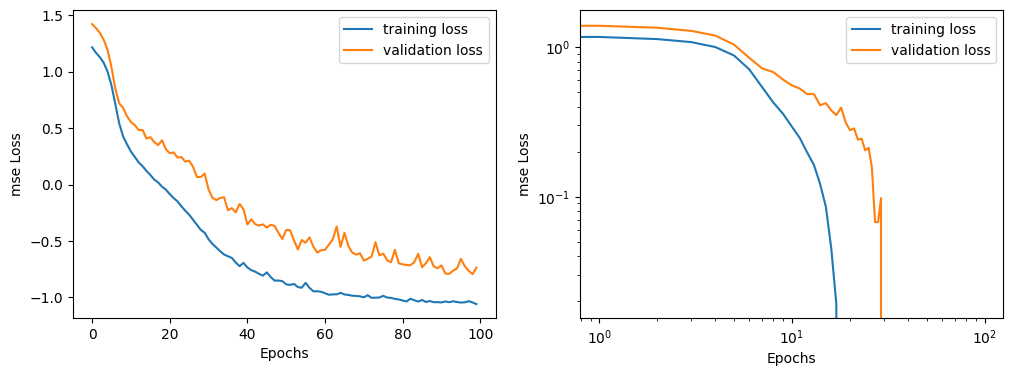

In [40]:
# Plot the loss function over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.plot(history.history["loss"], label="training loss")
ax1.plot(history.history["val_loss"], label="validation loss")
ax1.legend()
ax1.set_xlabel("Epochs")
ax1.set_ylabel(f"{loss} Loss")

ax2.loglog(history.history["loss"], label="training loss")
ax2.loglog(history.history["val_loss"], label="validation loss")
ax2.legend()
ax2.set_xlabel("Epochs")
ax2.set_ylabel(f"{loss} Loss")
plt.show()

This model is simultaneously predicting the mean and the standard deviation of given the inputs, so the evaluation will look a little different than before.

In [43]:
# Evaluate the model performance on train and validation data, extract the means and standard deviations
pred_norm = model_aleatoric(x_norm, training=False)
pred_norm_train = model_aleatoric(x_train, training=False)
pred_norm_val = model_aleatoric(x_val, training=False)
pred_norm_test = model_aleatoric(x_test, training=False)

# Unscale the results for the means and standard deviations separately
pred_mean_full = y_normalizer.inverse_transform(pred_norm[:, :n_targets])
pred_std_full = y_normalizer.inverse_transform(pred_norm[:, n_targets:])
pred_mean_train = y_normalizer.inverse_transform(pred_norm_train[:, :n_targets])
pred_std_train = y_normalizer.inverse_transform(pred_norm_train[:, n_targets:])
pred_mean_val = y_normalizer.inverse_transform(pred_norm_val[:, :n_targets])
pred_std_val = y_normalizer.inverse_transform(pred_norm_val[:, n_targets:])
pred_mean_test = y_normalizer.inverse_transform(pred_norm_test[:, :n_targets])
pred_std_test = y_normalizer.inverse_transform(pred_norm_test[:, n_targets:])



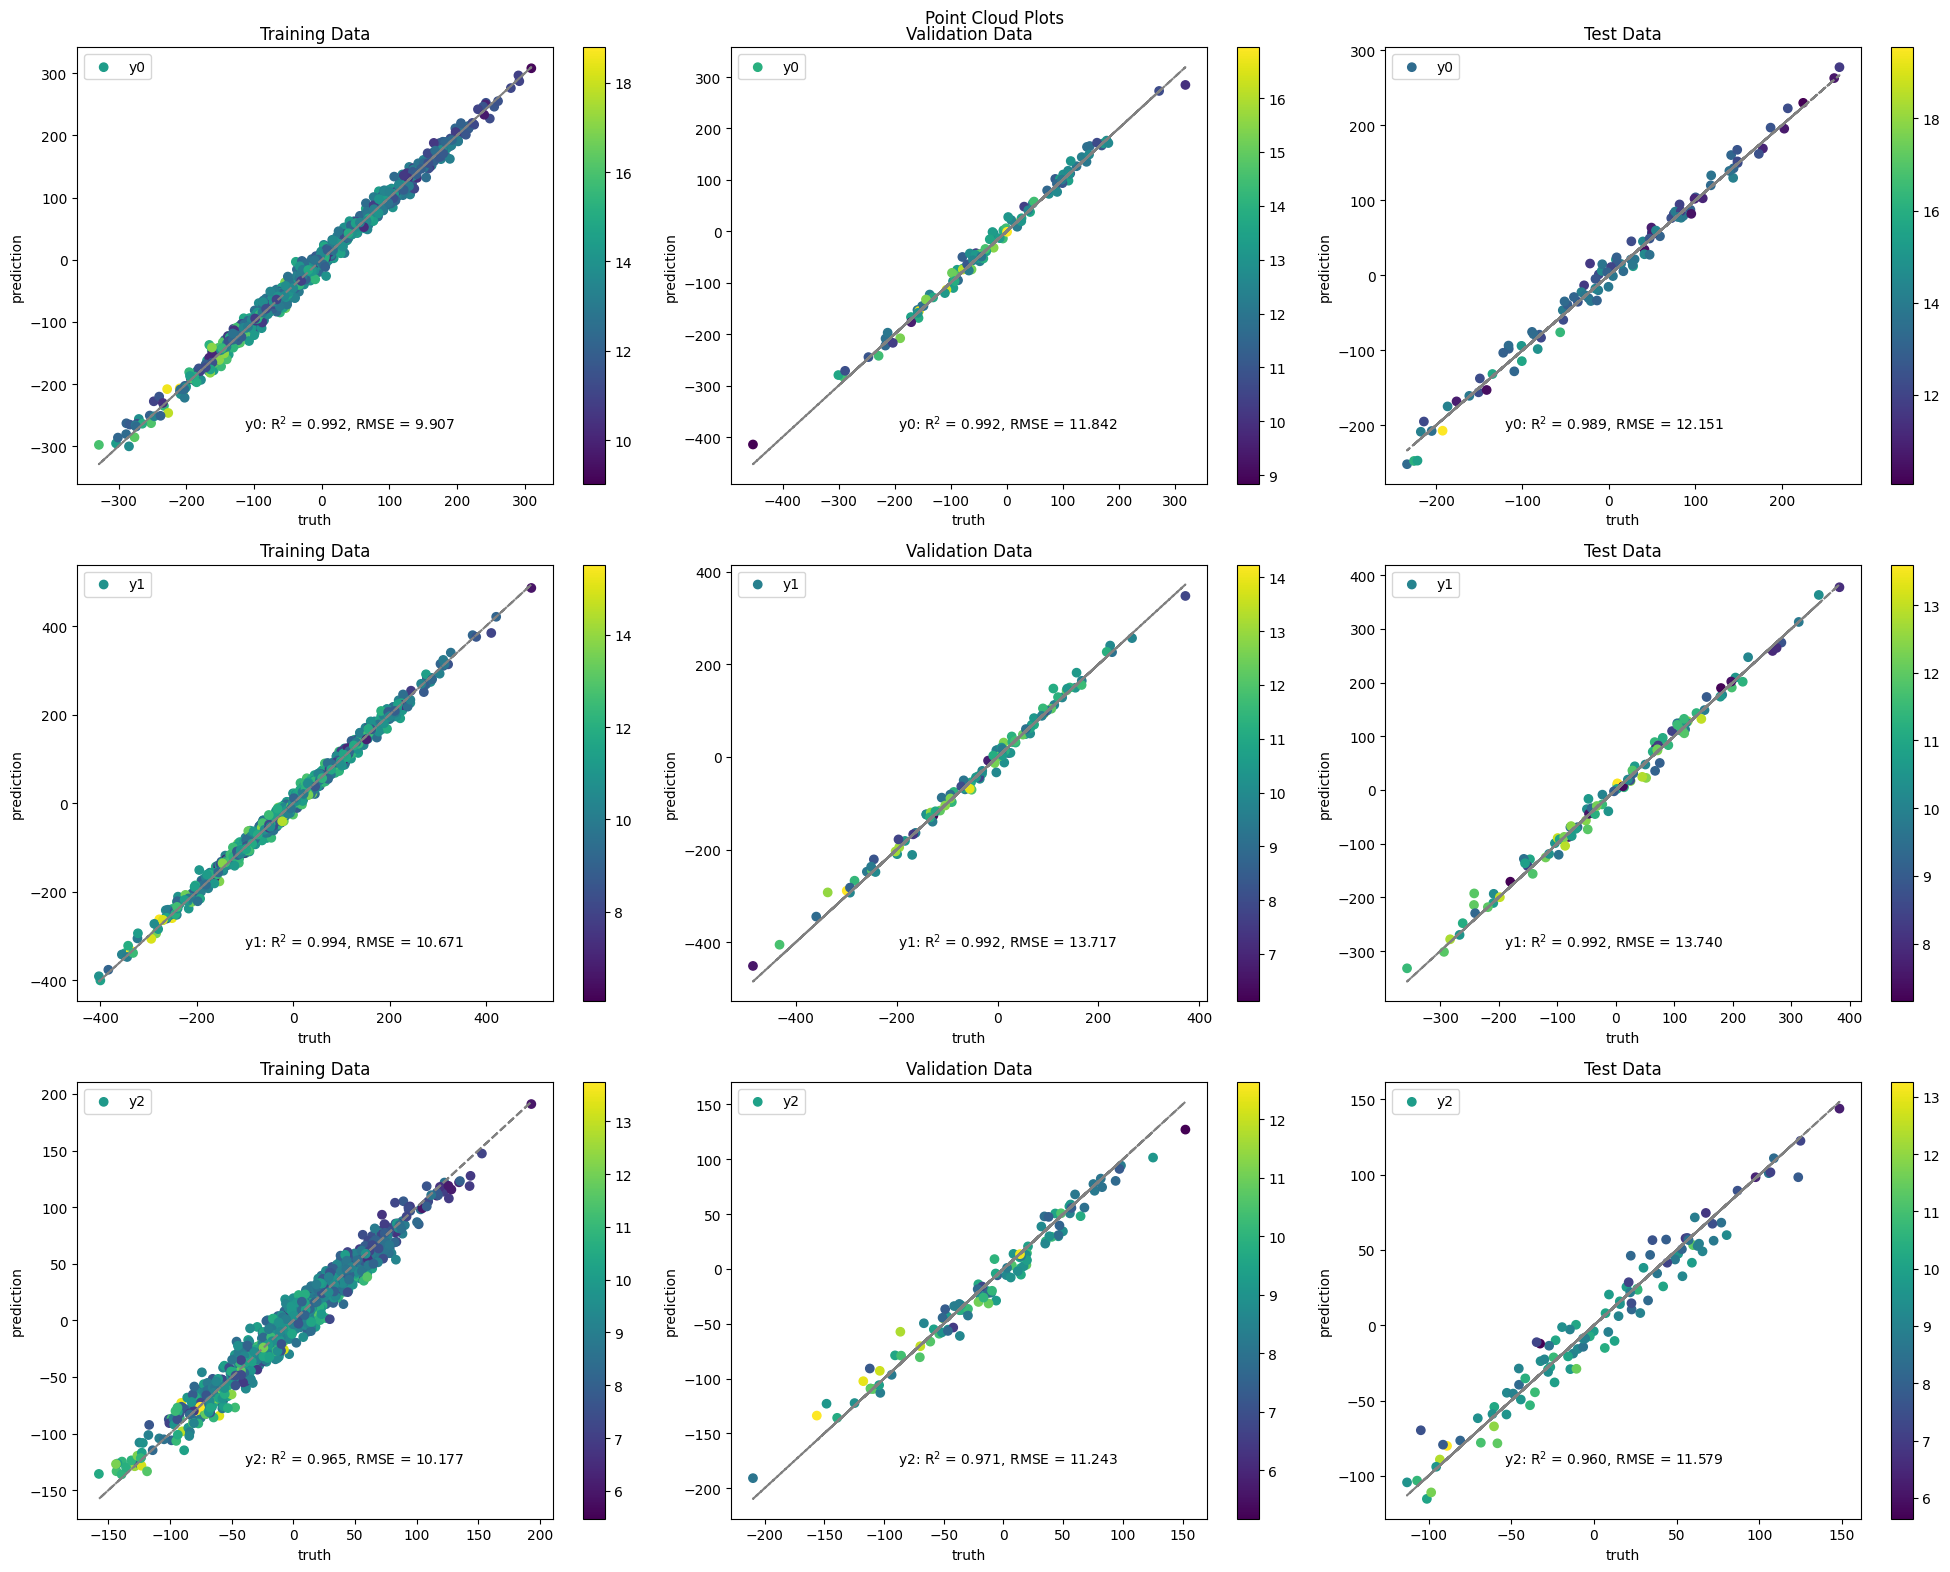

In [44]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/truth)**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_mean_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_mean_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_mean_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    # ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
    ax1.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Point Cloud Plots')
fig.tight_layout()
plt.show()

### ANN UQ Results
We see that the Epistemic uncertainty can be estimated through a Monte Carlo Dropout method which tends to place higher model uncertainey on the points near the ends of the training dataset and the Aleatoric uncertainty can be estimated by modifying the ANN to directly predict means and standard deviations of all data points. The Aleatoric uncertainty shows a relatively constant standard deviation prediction (although there is some variance therein) which is consistent with the constant data noise that we have applied to the model.

<hr style="border:50px solid white"> </hr>

# Bayesian Last Layer (BLL)
Now we will build a neural network with a Bayesian Last Layer for Aleatoric and Epistemic predictions.

We can recreate the data for convenience here (to avoid having to scroll up to the beginning of the document).

In [45]:
# Import the sklearn datasets
import sklearn.datasets as sdt
import numpy as np
import matplotlib.pyplot as plt

# Create a non-linear distribution using the sklearn make_regression function
n_samples = 1000
n_feats = 10
n_info = 5
n_targets = 3
noise = 10

x, y = sdt.make_regression(n_samples=n_samples, n_features=n_feats, n_informative=n_info, n_targets=n_targets, noise=noise, random_state=42)

print(f"Shape of x: {x.shape}", f"Shape of y: {y.shape}")

Shape of x: (1000, 10) Shape of y: (1000, 3)


In [46]:
# Use sklearn scaling libraries so we can iterate on data scaling methods easier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split

# norm_type = "minmax"
# norm_type = "standard"
norm_type = "robust"
# norm_type = "power"
# norm_type = "quantile"

if norm_type == "standard":
    x_normalizer = StandardScaler()
    y_normalizer = StandardScaler()
elif norm_type == "minmax":
    feature_range = (0, 1)
    x_normalizer = MinMaxScaler(feature_range=feature_range)
    y_normalizer = MinMaxScaler(feature_range=feature_range)
elif norm_type == "robust":
    quantile_range = (25, 75)
    x_normalizer = RobustScaler(quantile_range=quantile_range)
    y_normalizer = RobustScaler(quantile_range=quantile_range)
elif norm_type == "power":
    x_normalizer = PowerTransformer()
    y_normalizer = PowerTransformer()
elif norm_type == "quantile":
    dist_type = 'normal'
    x_normalizer = QuantileTransformer(output_distribution=dist_type)
    y_normalizer = QuantileTransformer(output_distribution=dist_type)


x_normalizer.fit(x)
y_normalizer.fit(y)

x_norm = x_normalizer.transform(x)
y_norm = y_normalizer.transform(y)

# Create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

## BLL Implementation Notes
We could go step by step and create different model classes as we did for the ANN section, but instead we are going to create a master BLL class that is able to take options as inputs depending upon the type of UQ model that we want to train.

* Epistemic: For model UQ in a BLL, we will set the last layer to a `DenseFlipout` layer that maintains a distributino over its weights.
* Aleatoric: For data UQ in a BLL, we will set the last layer to a `DistributionLambda` layer that returns a Tensorflow probability distribution.
* Combined: To create a single BLL model for both forms of UQ, we will *cheat* and use a combination of a `DenseFlipout` layer that feeds into a `DistributionLambda` layer. While not strickly a *last layer* model anymore, this represents a drastic reduction in complexity from a full BNN.

In [48]:
# Create the bayesian last layer model
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2
import tensorflow as tf
import tensorflow_probability as tfp

# Create a Bayesian last layer model class that inherits from the ANN class
class BayesianLastLayer(ANN):
    """
    A subclass of ANN that implements a Bayesian last layer.
    """
    def __init__(self, width, l1_norm, l2_norm, n_targets, n_samples, do_aleatoric=False, do_epistemic=False):
        super(BayesianLastLayer, self).__init__(width, l1_norm, l2_norm, n_targets)
        # Set up kernel divergence for DenseFlipout layers
        kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (n_samples * 1.0)

        # Output layer for epistemic uncertainty
        self.epistemic_output = tfp.layers.DenseFlipout(
            n_targets, 
            kernel_divergence_fn=kernel_divergence_fn, 
            activation='linear', 
            activity_regularizer=L1L2(l1=l1_norm, l2=l2_norm),
        )
        self.epistemic_aleatoric_layer = tfp.layers.DenseFlipout(
            n_targets * 2, 
            kernel_divergence_fn=kernel_divergence_fn, 
            activation='linear', 
            activity_regularizer=L1L2(l1=l1_norm, l2=l2_norm),
        )
        
        # Output layer for aleatoric uncertainty
        self.pre_aleatoric_output = Dense(n_targets * 2, activation='linear', kernel_regularizer=L1L2(l1=l1_norm, l2=l2_norm))
        self.aleatoric_output = tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(loc=t[..., :n_targets], scale=1e-3 + 0.1 * tf.math.softplus(t[..., n_targets:]))
        )

        self.do_aleatoric = do_aleatoric
        self.do_epistemic = do_epistemic

    def call(self, x):
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        if self.do_aleatoric and self.do_epistemic:
            x = self.epistemic_aleatoric_layer(x)
            return self.aleatoric_output(x)
        elif self.do_aleatoric:
            x = self.pre_aleatoric_output(x)
            return self.aleatoric_output(x)
        elif self.do_epistemic:
            return self.epistemic_output(x)
        else:
            return self.output_layer(x)
        
    def custom_loss(self, y_true, y_pred):
        if self.do_aleatoric:
            return -y_pred.log_prob(y_true) # NLL loss
        else:
            return tf.reduce_mean(tf.square(y_true - y_pred)) # MSE loss
        
# Compile the model
width = 10
l1_norm = 1e-3
l2_norm = 1e-3
learning_rate = 1e-3
n_samples = x.shape[0]

    

By chaging the `do_aleatoric` and `do_epistemic` flags, the above model can act as a standard ANN model or can use Bayesian layers to approximate aleatoric/epistemic uncertainties.

Let's see how these uncertainty approximations compare to those of the ANN...

In [53]:
# First do a standard ANN with the model
do_aleatoric = False
do_epistemic = False

model_bll = BayesianLastLayer(
    width=width, 
    l1_norm=l1_norm, 
    l2_norm=l2_norm, 
    n_targets=n_targets, 
    n_samples=n_samples, 
    do_aleatoric=do_aleatoric, 
    do_epistemic=do_epistemic,
)

model_bll.compile(optimizer=Adam(learning_rate=learning_rate), loss=model_bll.custom_loss)

# Print the model summary
model_bll.build(input_shape=(n_samples, n_feats))
model_bll.summary()

Model: "bayesian_last_layer_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_77 (Dense)            multiple                  110       
                                                                 
 dense_78 (Dense)            multiple                  110       
                                                                 
 dense_79 (Dense)            multiple                  110       
                                                                 
 dense_80 (Dense)            multiple                  33        
                                                                 
 dense_flipout_4 (DenseFlipo  multiple                 0 (unused)
 ut)                                                             
                                                                 
 dense_flipout_5 (DenseFlipo  multiple                 0 (unused)
 ut)                                         

In [54]:
# train the model
batch_size = 32
history = model_bll.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/100


25/25 [==============================] - 1s 7ms/step - loss: 0.6178 - val_loss: 0.7093
Epoch 2/100
25/25 [==============================] - 0s 2ms/step - loss: 0.5390 - val_loss: 0.6298
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4773 - val_loss: 0.5566
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: 0.4146 - val_loss: 0.4766
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3484 - val_loss: 0.3957
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2874 - val_loss: 0.3274
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2414 - val_loss: 0.2807
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: 0.2150 - val_loss: 0.2504
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1986 - val_loss: 0.2306
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 0.1862 - val_loss: 0.2127
Epoch 11/100
25/25 [=

In [55]:
# Evaluate the model performance on train and validation data
pred_norm = model_bll(x_norm, training=False)
pred_norm_train = model_bll(x_train, training=False)
pred_norm_val = model_bll(x_val, training=False)
pred_norm_test = model_bll(x_test, training=False)

# Unscale the results and plot
pred_full = y_normalizer.inverse_transform(pred_norm)
pred_train = y_normalizer.inverse_transform(pred_norm_train)
pred_val = y_normalizer.inverse_transform(pred_norm_val)
pred_test = y_normalizer.inverse_transform(pred_norm_test)

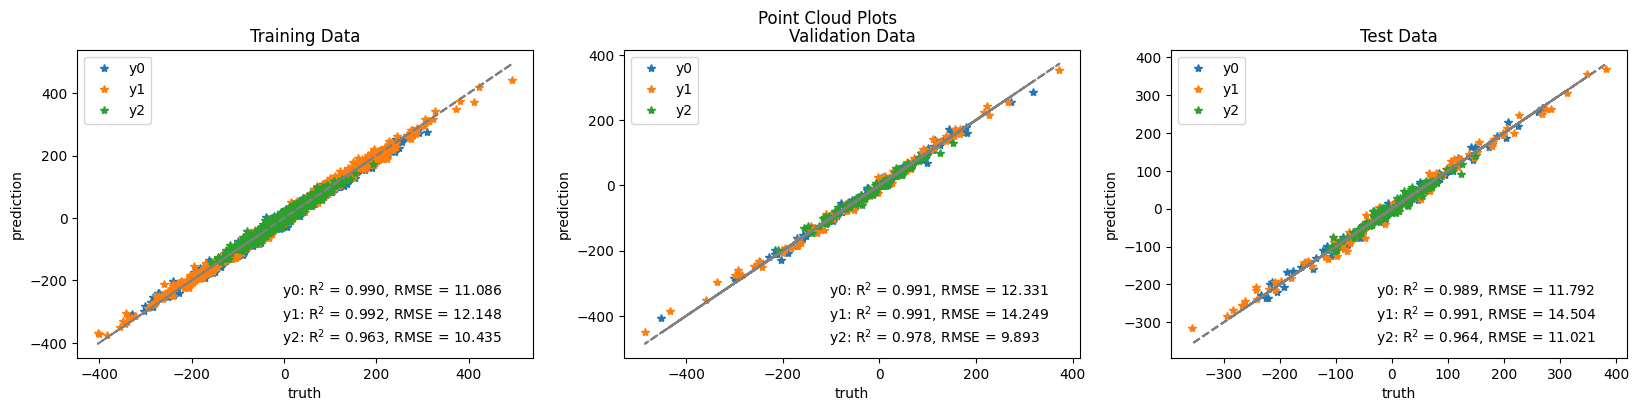

In [56]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/(truth+1e-6))**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
# Train plot
for i in range(n_targets):
    ax1.plot(y_train_real[:, i], pred_train[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    # ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
    ax1.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    # Validation plot
    ax2.plot(y_val_real[:, i], pred_val[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    # Test plot
    ax3.plot(y_test_real[:, i], pred_test[:, i], marker="*", linestyle="None", label=f"y{i}")
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.45, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")

fig.suptitle('Point Cloud Plots')
plt.show()

We are fitting to within the RMSE of the dataset noise just like the ANN model above.

Now let's switch to epistemic uncertainty estimation which uses the `DenseFlipout` layer to maintain a distributino of model weights for the final layer in the model.

In [57]:
# Now, lets model episemic uncertainty
do_aleatoric = False
do_epistemic = True

model_bll = BayesianLastLayer(
    width=width, 
    l1_norm=l1_norm, 
    l2_norm=l2_norm, 
    n_targets=n_targets, 
    n_samples=n_samples, 
    do_aleatoric=do_aleatoric, 
    do_epistemic=do_epistemic,
)

model_bll.compile(optimizer=Adam(learning_rate=learning_rate), loss=model_bll.custom_loss)

# Print the model summary
model_bll.build(input_shape=(n_samples, n_feats))
model_bll.summary()

Model: "bayesian_last_layer_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            multiple                  110       
                                                                 
 dense_83 (Dense)            multiple                  110       
                                                                 
 dense_84 (Dense)            multiple                  110       
                                                                 
 dense_85 (Dense)            multiple                  0 (unused)
                                                                 
 dense_flipout_6 (DenseFlipo  multiple                 63        
 ut)                                                             
                                                                 
 dense_flipout_7 (DenseFlipo  multiple                 0 (unused)
 ut)                                         

/home/nick/miniconda3/envs/mlmd/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/nick/miniconda3/envs/mlmd/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [58]:
# train the model
batch_size = 32
history = model_bll.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=100,
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/100
25/25 [==============================] - 1s 11ms/step - loss: 0.7323 - val_loss: 0.8975
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6946 - val_loss: 0.8755
Epoch 3/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6712 - val_loss: 0.8244
Epoch 4/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6436 - val_loss: 0.7607
Epoch 5/100
25/25 [==============================] - 0s 3ms/step - loss: 0.6018 - val_loss: 0.6696
Epoch 6/100
25/25 [==============================] - 0s 3ms/step - loss: 0.5415 - val_loss: 0.5579
Epoch 7/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4632 - val_loss: 0.4366
Epoch 8/100
25/25 [==============================] - 0s 3ms/step - loss: 0.4008 - val_loss: 0.3922
Epoch 9/100
25/25 [==============================] - 0s 3ms/step - loss: 0.3579 - val_loss: 0.3253
Epoch 10/100
25/25 [==============================] - 0s 2ms/step - loss: 0.3233 - val_loss: 0.3115
Epoch 11

In [59]:
# Evaluate the model performance on train and validation data using an ensemble of predictions
num_preds = 100
pred_norm = np.stack([model_bll(x_norm, training=False) for _ in range(num_preds)], axis=0)
pred_norm_train = np.stack([model_bll(x_train, training=False) for _ in range(num_preds)], axis=0)
pred_norm_val = np.stack([model_bll(x_val, training=False) for _ in range(num_preds)], axis=0)
pred_norm_test = np.stack([model_bll(x_test, training=False) for _ in range(num_preds)], axis=0)

# First, unscale the results of the ensemble before computing the statistics
pred_full = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm], axis=0)
pred_train = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_train], axis=0)
pred_val = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_val], axis=0)
pred_test = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_test], axis=0)

# Compute the mean and standard deviation of the predictions
pred_mean = np.mean(pred_full, axis=0)
pred_std = np.std(pred_full, axis=0)
pred_mean_train = np.mean(pred_train, axis=0)
pred_std_train = np.std(pred_train, axis=0)
pred_mean_val = np.mean(pred_val, axis=0)
pred_std_val = np.std(pred_val, axis=0)
pred_mean_test = np.mean(pred_test, axis=0)
pred_std_test = np.std(pred_test, axis=0)

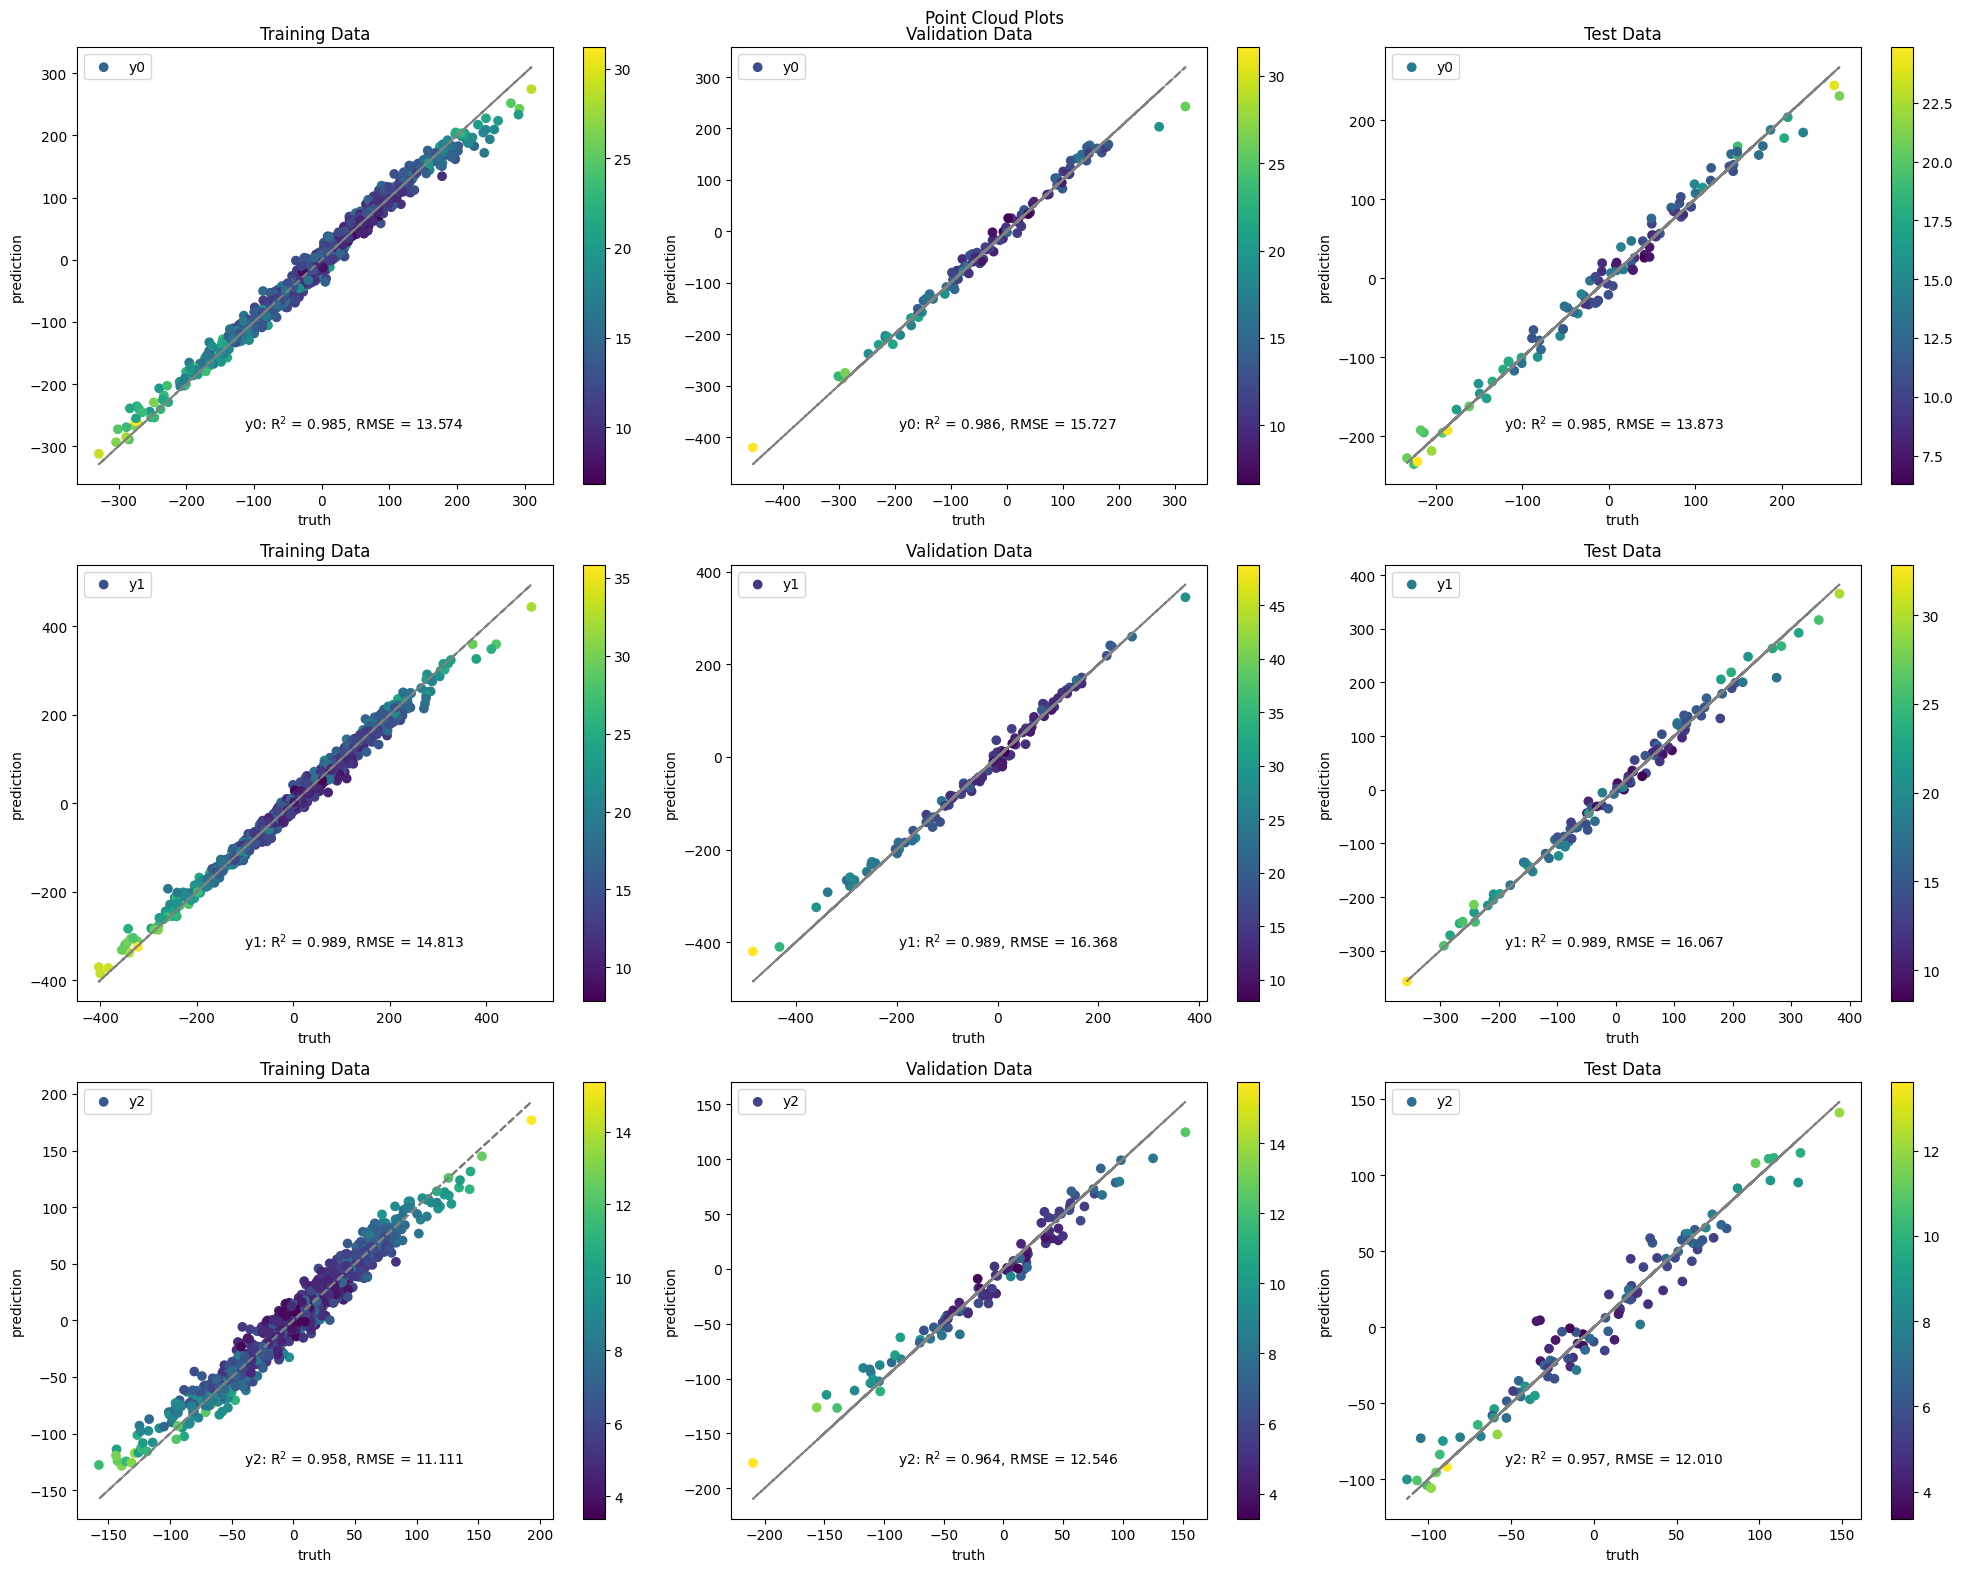

In [60]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/truth)**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_mean_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_mean_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_mean_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    # ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
    ax1.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Point Cloud Plots')
fig.tight_layout()
plt.show()

We see similar performance to the ANN's Monte Carlo Dropout estimation of the Epistemic Uncertainty. We can run tests to compare the stability of the training and the final results for both methods, but that will need to be the subject of a different notebook.

Now, lets look at the aleatoric uncertainty estimation for the BLL...

In [61]:
# Now, lets model aleatoric uncertainty
do_aleatoric = True
do_epistemic = False

model_bll = BayesianLastLayer(
    width=width, 
    l1_norm=l1_norm, 
    l2_norm=l2_norm, 
    n_targets=n_targets, 
    n_samples=n_samples, 
    do_aleatoric=do_aleatoric, 
    do_epistemic=do_epistemic,
)

model_bll.compile(optimizer=Adam(learning_rate=learning_rate), loss=model_bll.custom_loss)

# Print the model summary
model_bll.build(input_shape=(n_samples, n_feats))
model_bll.summary()

Model: "bayesian_last_layer_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_87 (Dense)            multiple                  110       
                                                                 
 dense_88 (Dense)            multiple                  110       
                                                                 
 dense_89 (Dense)            multiple                  110       
                                                                 
 dense_90 (Dense)            multiple                  0 (unused)
                                                                 
 dense_flipout_8 (DenseFlipo  multiple                 0 (unused)
 ut)                                                             
                                                                 
 dense_flipout_9 (DenseFlipo  multiple                 0 (unused)
 ut)                                         

In [71]:
# train the model
batch_size = 32
history = model_bll.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/100
 1/25 [>.............................] - ETA: 0s - loss: -0.4281

25/25 [==============================] - 0s 4ms/step - loss: -0.3726 - val_loss: -0.3073
Epoch 2/100
25/25 [==============================] - 0s 3ms/step - loss: -0.3829 - val_loss: -0.3093
Epoch 3/100
25/25 [==============================] - 0s 2ms/step - loss: -0.3916 - val_loss: -0.3185
Epoch 4/100
25/25 [==============================] - 0s 2ms/step - loss: -0.4000 - val_loss: -0.3229
Epoch 5/100
25/25 [==============================] - 0s 2ms/step - loss: -0.4097 - val_loss: -0.3353
Epoch 6/100
25/25 [==============================] - 0s 2ms/step - loss: -0.4167 - val_loss: -0.3403
Epoch 7/100
25/25 [==============================] - 0s 2ms/step - loss: -0.4272 - val_loss: -0.3555
Epoch 8/100
25/25 [==============================] - 0s 2ms/step - loss: -0.4372 - val_loss: -0.3630
Epoch 9/100
25/25 [==============================] - 0s 2ms/step - loss: -0.4457 - val_loss: -0.3701
Epoch 10/100
25/25 [==============================] - 0s 3ms/step - loss: -0.4532 - val_loss: -0.3827
E

In [72]:
# Evaluate the model performance on train and validation data, extract the means and standard deviations
pred_norm = model_bll(x_norm, training=False)
pred_norm_train = model_bll(x_train, training=False)
pred_norm_val = model_bll(x_val, training=False)
pred_norm_test = model_bll(x_test, training=False)

# Unscale the results for the means and standard deviations separately
pred_mean_full = y_normalizer.inverse_transform(pred_norm.mean().numpy())
pred_std_full = y_normalizer.inverse_transform(pred_norm.stddev().numpy())
pred_mean_train = y_normalizer.inverse_transform(pred_norm_train.mean().numpy())
pred_std_train = y_normalizer.inverse_transform(pred_norm_train.stddev().numpy())
pred_mean_val = y_normalizer.inverse_transform(pred_norm_val.mean().numpy())
pred_std_val = y_normalizer.inverse_transform(pred_norm_val.stddev().numpy())
pred_mean_test = y_normalizer.inverse_transform(pred_norm_test.mean().numpy())
pred_std_test = y_normalizer.inverse_transform(pred_norm_test.stddev().numpy())

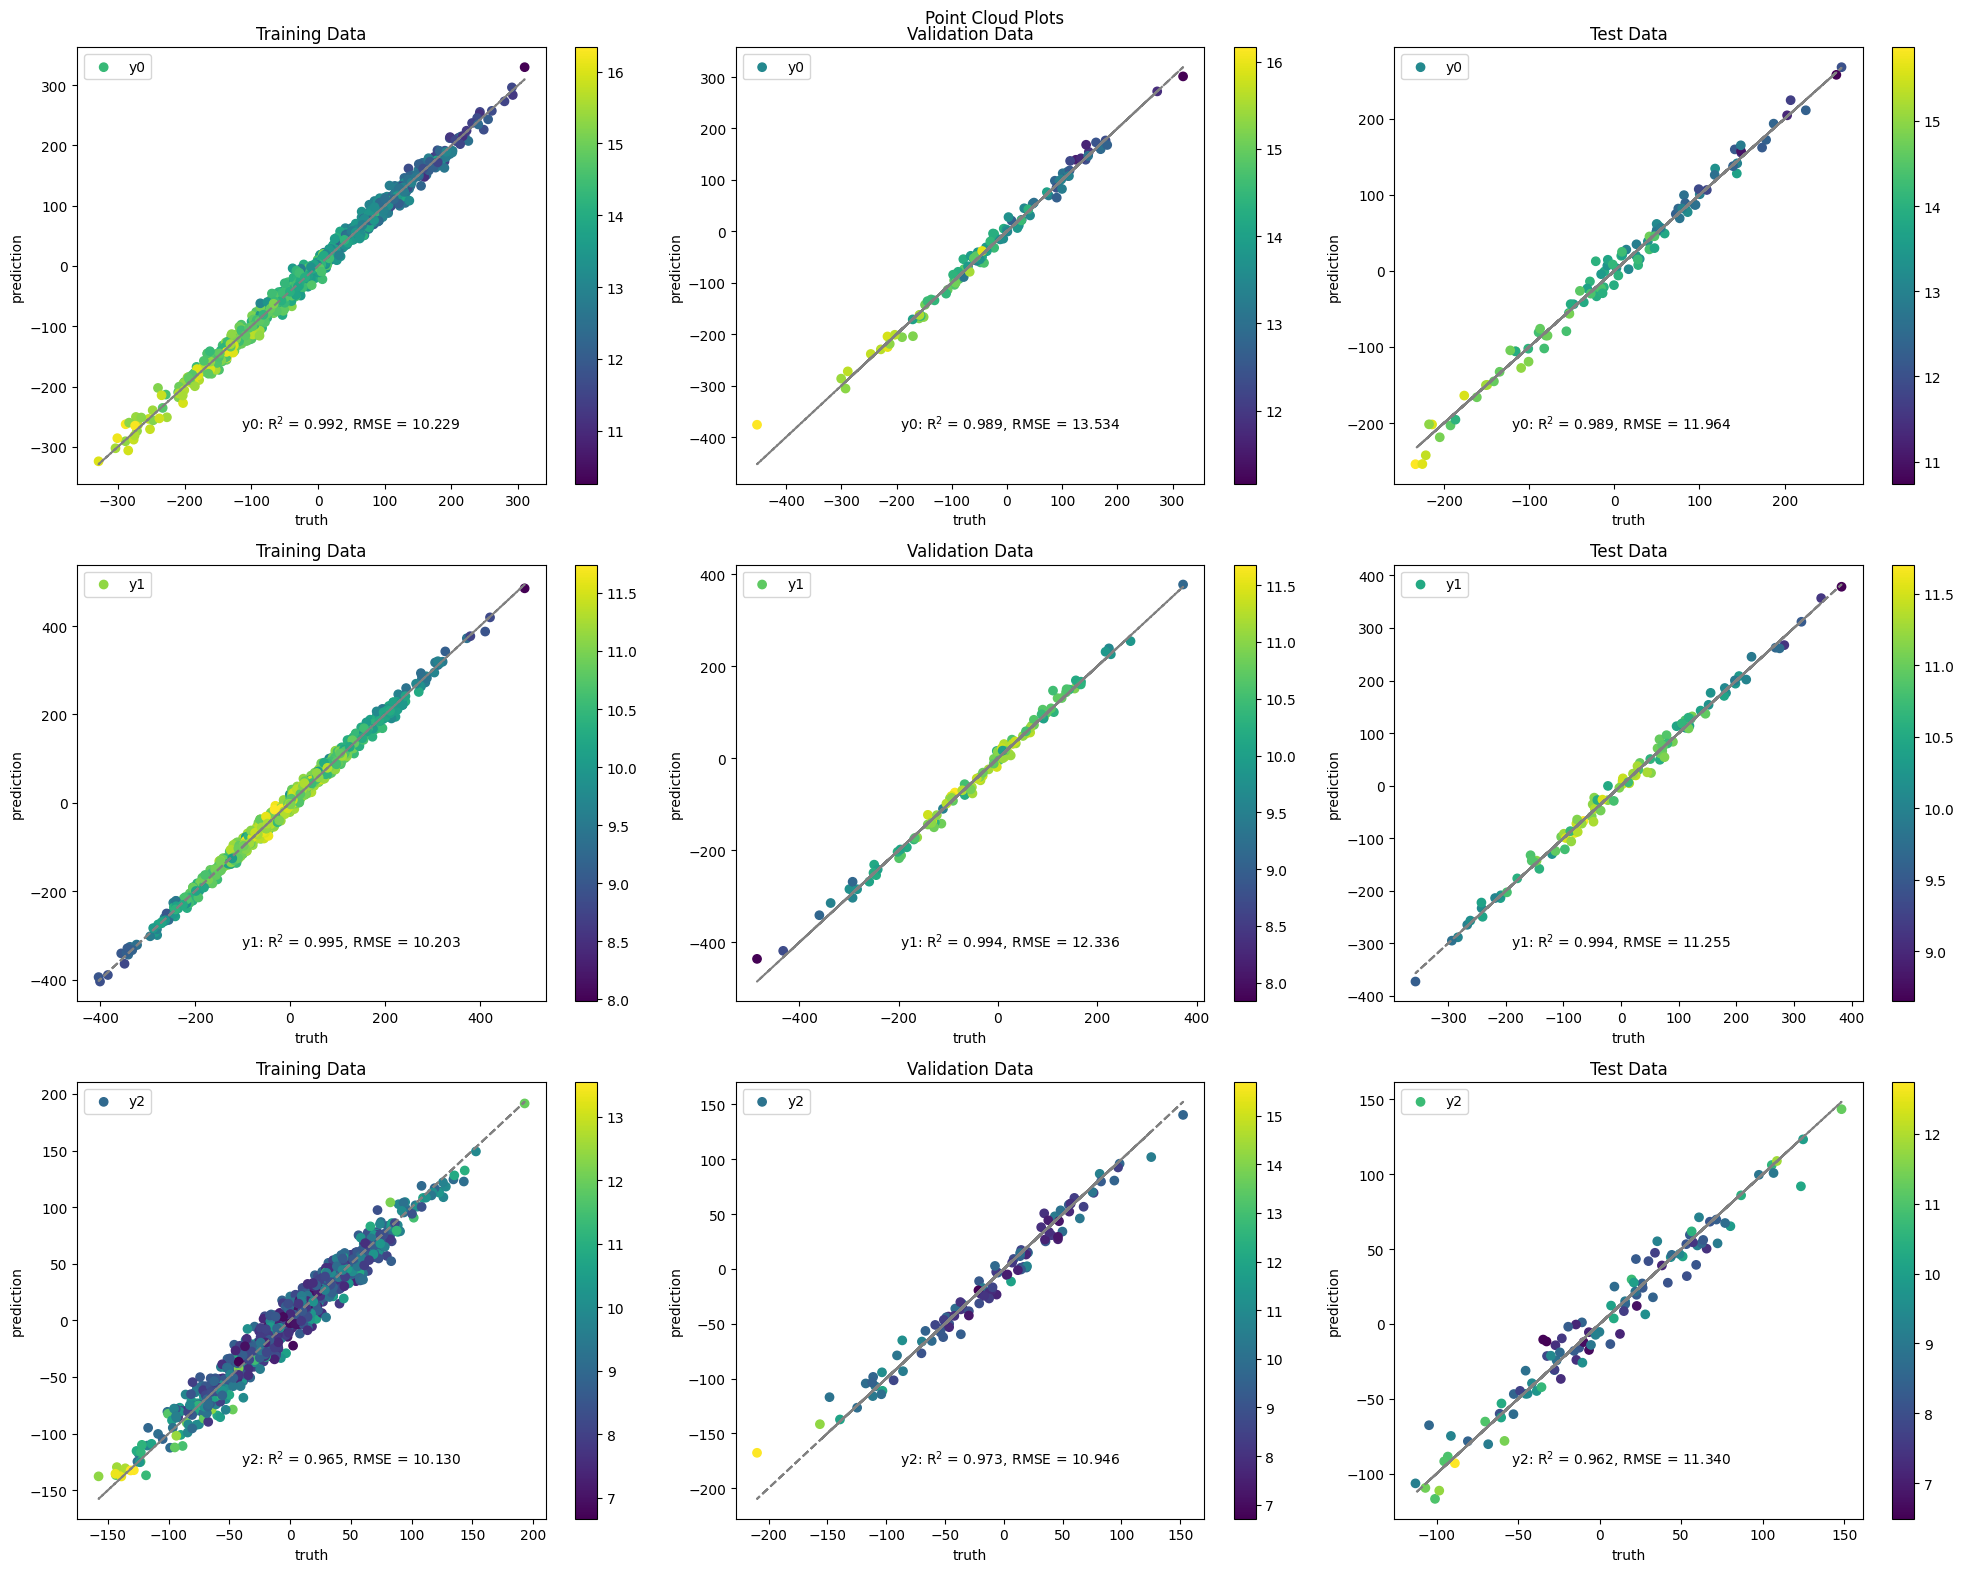

In [73]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/truth)**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_mean_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_mean_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_mean_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    # ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
    ax1.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Point Cloud Plots')
fig.tight_layout()
plt.show()

Again, the aleatoric uncertainy estimation provides comparable results to that of the ANN method. And again, the uncertainty estimates correspond closly to the RMSE and the noise that was introduced with the dataset generation.

Finally, let's do a combined UQ approach using a BLL with *two final* Bayesian layers, the first is a `DenseFlipout` and the final is a `DistributionLambda` function.

In [74]:
# Now, lets model aleatoric uncertainty
do_aleatoric = True
do_epistemic = True

model_bll = BayesianLastLayer(
    width=width, 
    l1_norm=l1_norm, 
    l2_norm=l2_norm, 
    n_targets=n_targets, 
    n_samples=n_samples, 
    do_aleatoric=do_aleatoric, 
    do_epistemic=do_epistemic,
)

model_bll.compile(optimizer=Adam(learning_rate=learning_rate), loss=model_bll.custom_loss)

# Print the model summary
model_bll.build(input_shape=(n_samples, n_feats))
model_bll.summary()

Model: "bayesian_last_layer_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_92 (Dense)            multiple                  110       
                                                                 
 dense_93 (Dense)            multiple                  110       
                                                                 
 dense_94 (Dense)            multiple                  110       
                                                                 
 dense_95 (Dense)            multiple                  0 (unused)
                                                                 
 dense_flipout_10 (DenseFlip  multiple                 0 (unused)
 out)                                                            
                                                                 
 dense_flipout_11 (DenseFlip  multiple                 126       
 out)                                        

/home/nick/miniconda3/envs/mlmd/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/nick/miniconda3/envs/mlmd/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [75]:
# train the model
batch_size = 32
history = model_bll.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/200
25/25 [==============================] - 2s 12ms/step - loss: 51.8318 - val_loss: 64.6784
Epoch 2/200
25/25 [==============================] - 0s 3ms/step - loss: 44.7432 - val_loss: 54.9228
Epoch 3/200
25/25 [==============================] - 0s 3ms/step - loss: 37.0948 - val_loss: 41.0206
Epoch 4/200
25/25 [==============================] - 0s 3ms/step - loss: 28.1437 - val_loss: 29.0441
Epoch 5/200
25/25 [==============================] - 0s 3ms/step - loss: 19.3016 - val_loss: 17.9138
Epoch 6/200
25/25 [==============================] - 0s 4ms/step - loss: 11.9382 - val_loss: 10.9968
Epoch 7/200
25/25 [==============================] - 0s 3ms/step - loss: 7.2179 - val_loss: 6.6354
Epoch 8/200
25/25 [==============================] - 0s 4ms/step - loss: 4.6854 - val_loss: 4.0145
Epoch 9/200
25/25 [==============================] - 0s 4ms/step - loss: 3.1073 - val_loss: 3.1351
Epoch 10/200
25/25 [==============================] - 0s 3ms/step - loss: 2.3097 - val_loss: 2.7

Since this is a combined epistemic and aleatoric UQ approach, we will need to probe the model in a different way in order to assess the different forms of the uncertainty.

Since the second to last layer is a `DenseFlipout`, the whole model represents an ensemble model where the outputs from the `DenseFlipout` layer inform the final distribution for the aleatoric uncertainty approximation. Therefore, we should form an ensemble of predictions to gather an ensemble of distributions from the `DistributionLambda` layer, and then compute the statistics based on that final ensemble of distributions.

The various values are computed thusly:
* Mean predictions: The mean of the ensemble of the PDF means
* Epistemic uncertainty: The standard deviation of the ensemble of the PDF means
* Aleatoric uncertainty: The mean of the ensemble of the PDF standard deviations

In [83]:
# Evaluate the model performance on train and validation data using an ensemble of predictions with dropout enabled
num_preds = 100
pred_norm = np.stack([model_bll(x_norm, training=False) for _ in range(num_preds)], axis=0)
pred_norm_train = np.stack([model_bll(x_train, training=False) for _ in range(num_preds)], axis=0)
pred_norm_val = np.stack([model_bll(x_val, training=False) for _ in range(num_preds)], axis=0)
pred_norm_test = np.stack([model_bll(x_test, training=False) for _ in range(num_preds)], axis=0)

# We now have an ensemble of distributions from which we can extract the combined mean and standard deviations
# We will compute the prediction value as the mean of the ensemble of the distributions means
# We will compute the epistemic uncertainty as the standard deviation of the ensemble of the distributions means
# We will compute the aleatoric uncertainty as the mean of the ensemble of the distributions standard deviations
pred_mean_full = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm], axis=0).mean(axis=0)
pred_eu_full = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm], axis=0).std(axis=0)
pred_au_full = np.stack([y_normalizer.inverse_transform(y.stddev().numpy()) for y in pred_norm], axis=0).mean(axis=0)

pred_mean_train = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm_train], axis=0).mean(axis=0)
pred_eu_train = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm_train], axis=0).std(axis=0)
pred_au_train = np.stack([y_normalizer.inverse_transform(y.stddev().numpy()) for y in pred_norm_train], axis=0).mean(axis=0)

pred_mean_val = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm_val], axis=0).mean(axis=0)
pred_eu_val = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm_val], axis=0).std(axis=0)
pred_au_val = np.stack([y_normalizer.inverse_transform(y.stddev().numpy()) for y in pred_norm_val], axis=0).mean(axis=0)

pred_mean_test = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm_test], axis=0).mean(axis=0)
pred_eu_test = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm_test], axis=0).std(axis=0)
pred_au_test = np.stack([y_normalizer.inverse_transform(y.stddev().numpy()) for y in pred_norm_test], axis=0).mean(axis=0)

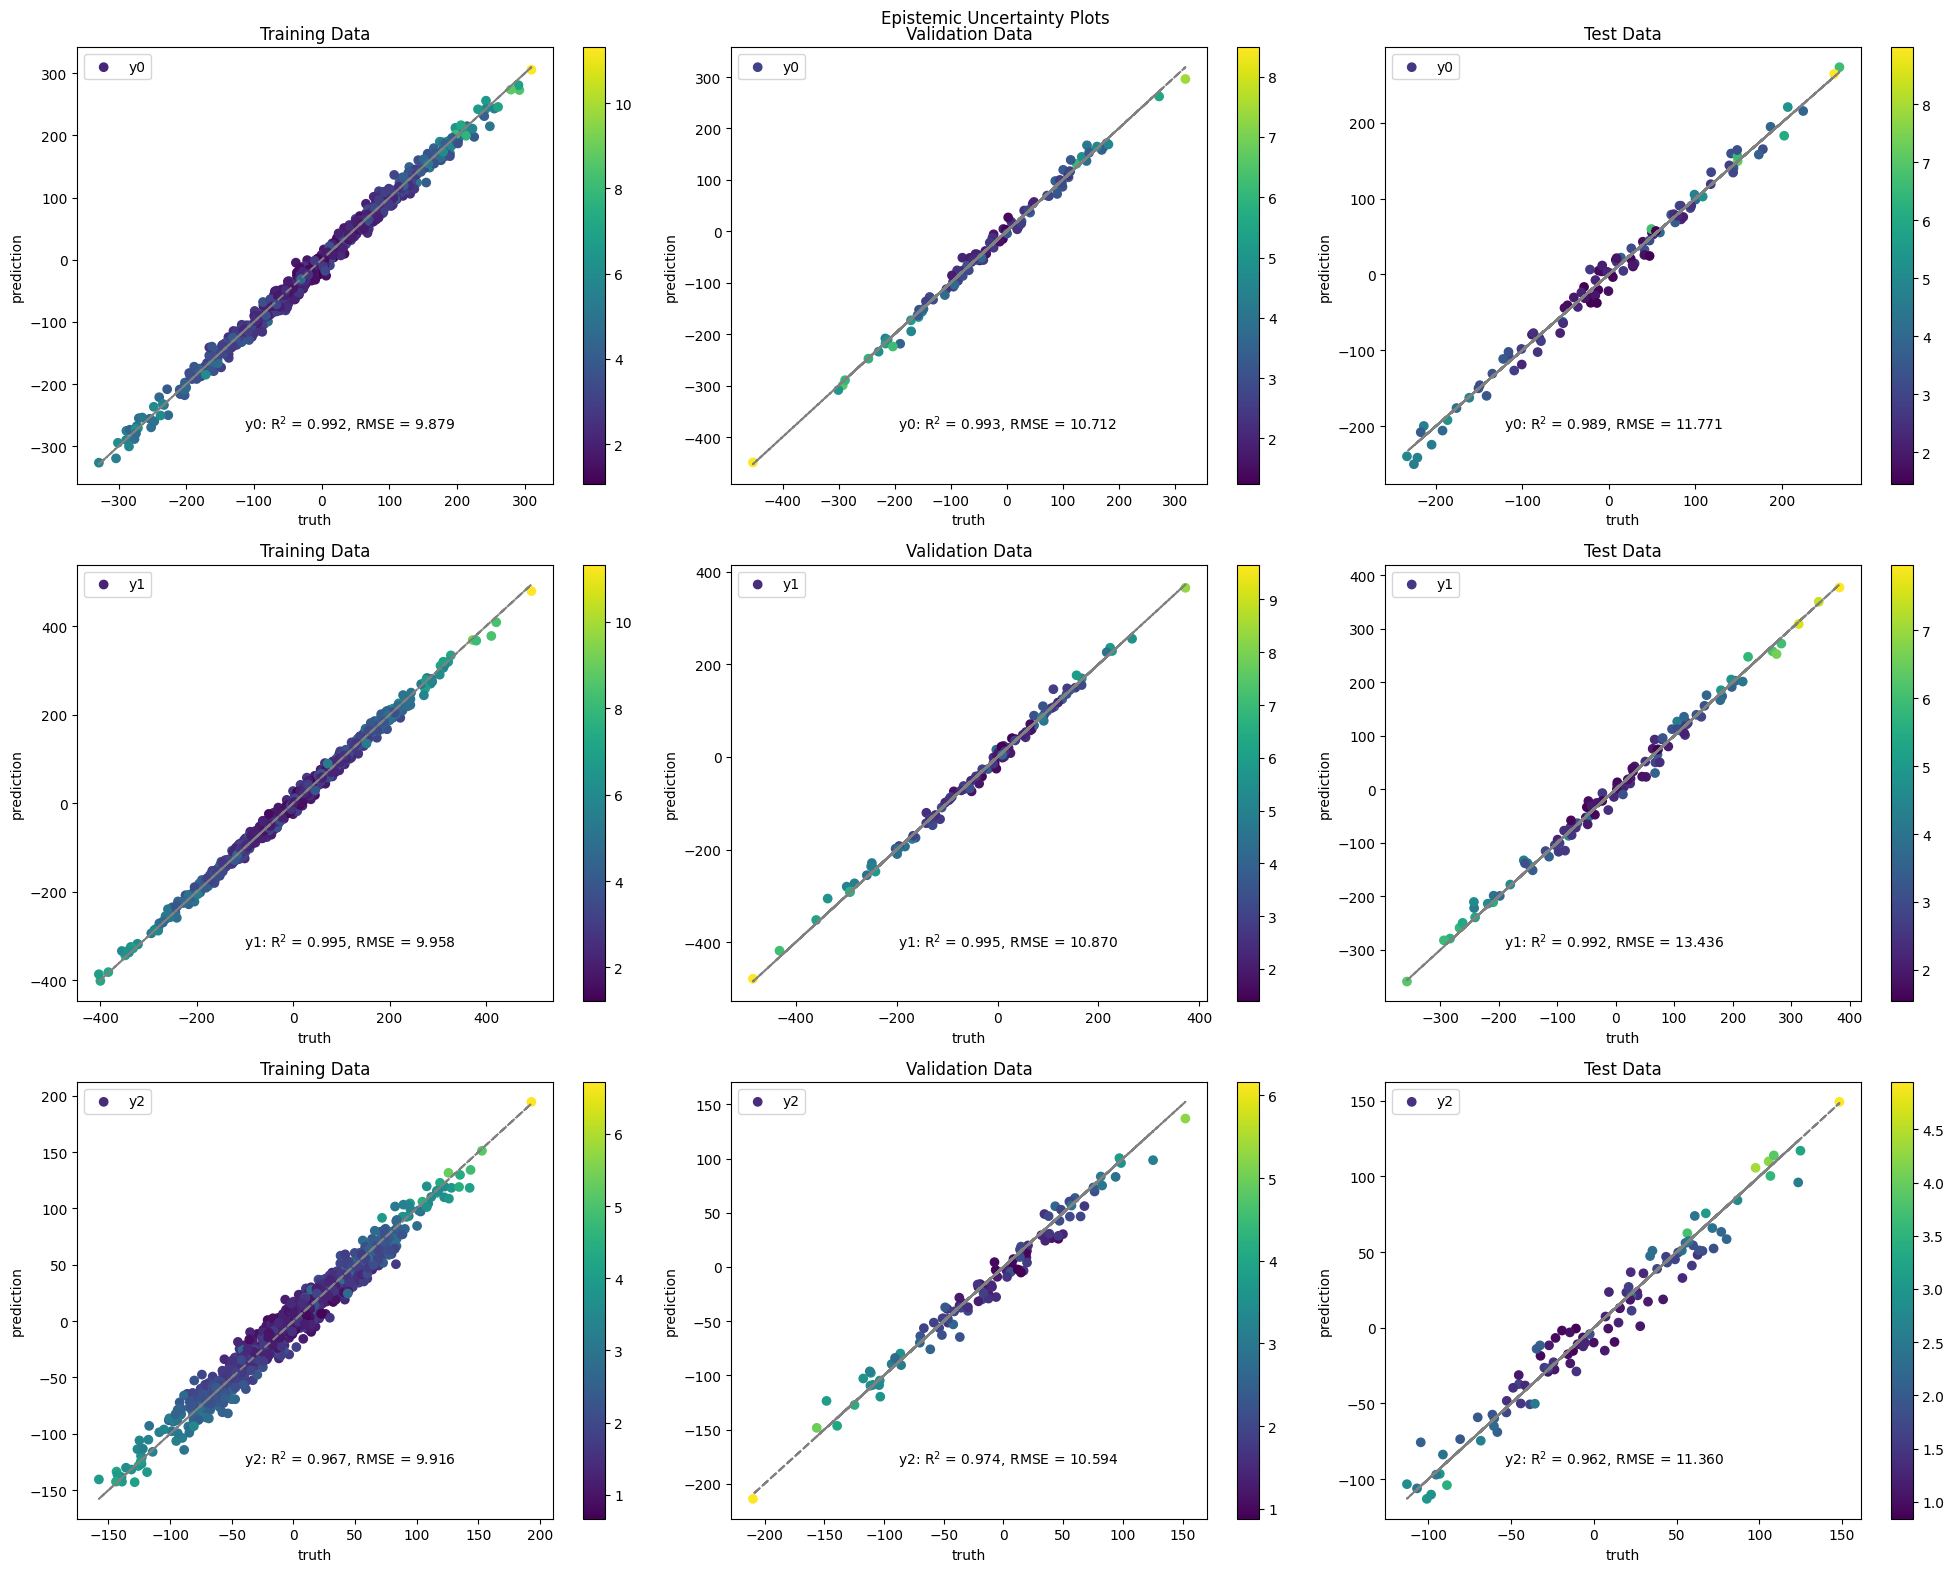

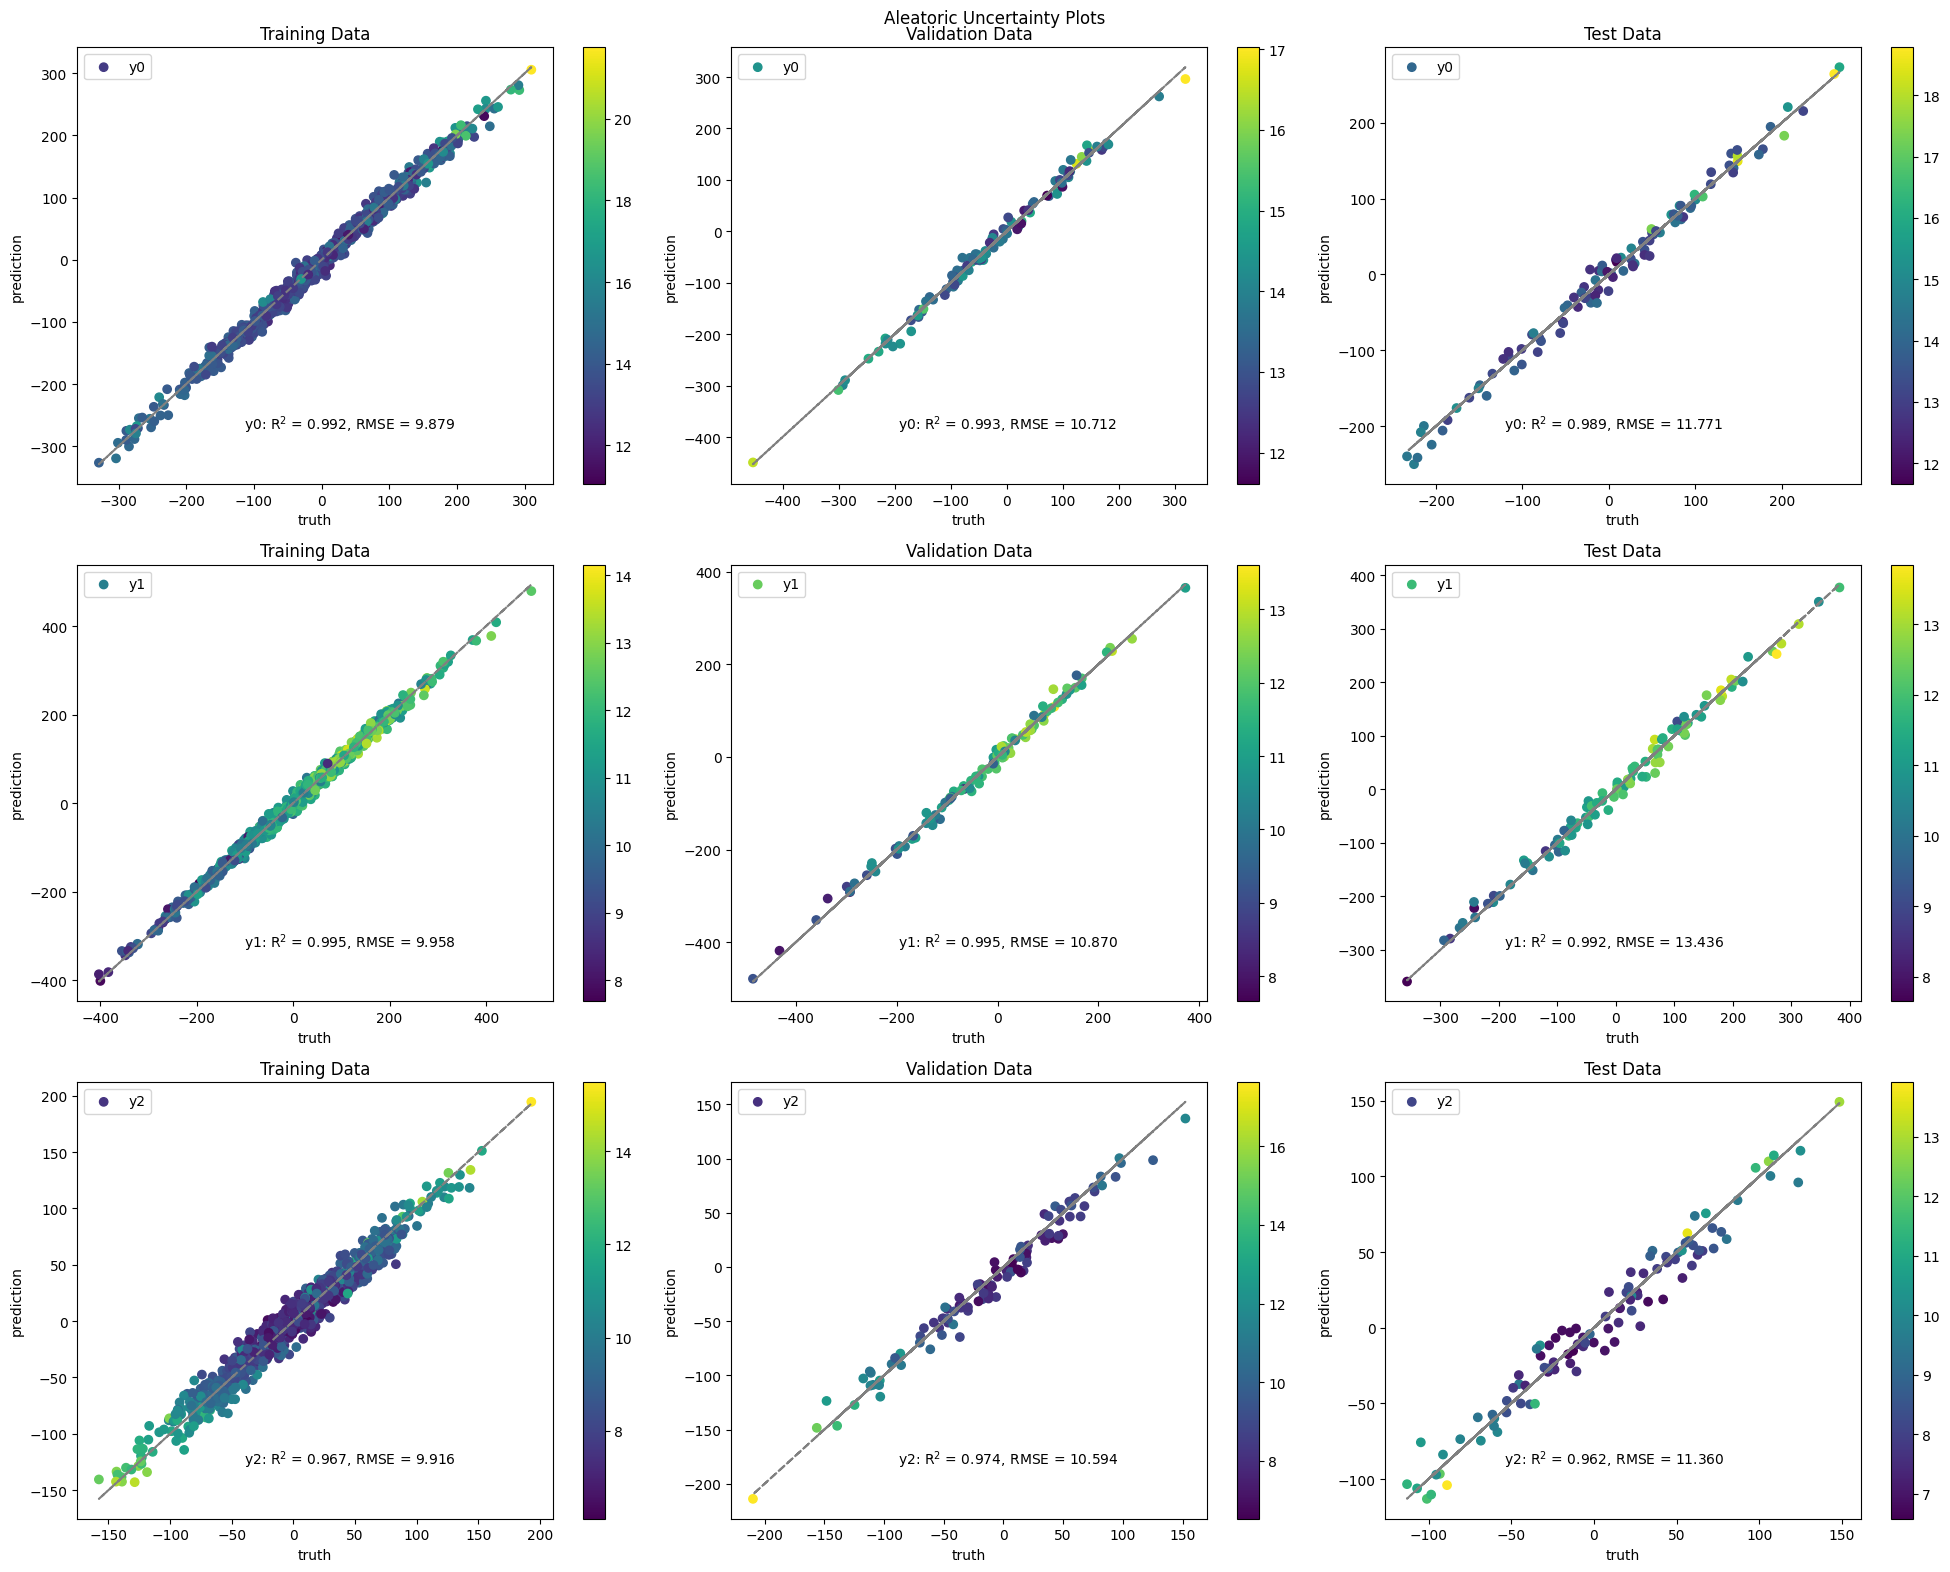

In [90]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/truth)**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_mean_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_mean_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_mean_test, y_test_real)


# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    ax1.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Epistemic Uncertainty Plots')
fig.tight_layout()
plt.show()

# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    ax1.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Aleatoric Uncertainty Plots')
fig.tight_layout()
plt.show()

### BLL Results
Overall, we get similar results using the BLL to the ANN, although the implementation is notably more consistent, and the ability to natively combine error estimates provides useful insight into the structure of the data and the uncertainties involved.

Overall we see that the Epistemic uncertainties tend to increase near the edges of the dataset and the Aleatoric uncertainties are more evenly distributed throughout the dataset (which is a consequence of the uniform noise applied).

<hr style="border:50px solid white"> </hr>

# Full Bayesian Neural Network (BNN)
Now we will build a full Bayesian neural network for Aleatoric and Epistemic predictions.

We can again recreate the data for convenience here (to avoid having to scroll up to the beginning of the document).

In [91]:
# Import the sklearn datasets
import sklearn.datasets as sdt
import numpy as np
import matplotlib.pyplot as plt

# Create a non-linear distribution using the sklearn make_regression function
n_samples = 1000
n_feats = 10
n_info = 5
n_targets = 3
noise = 10

x, y = sdt.make_regression(n_samples=n_samples, n_features=n_feats, n_informative=n_info, n_targets=n_targets, noise=noise, random_state=42)

print(f"Shape of x: {x.shape}", f"Shape of y: {y.shape}")

Shape of x: (1000, 10) Shape of y: (1000, 3)


In [92]:
# Use sklearn scaling libraries so we can iterate on data scaling methods easier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split

# norm_type = "minmax"
# norm_type = "standard"
norm_type = "robust"
# norm_type = "power"
# norm_type = "quantile"

if norm_type == "standard":
    x_normalizer = StandardScaler()
    y_normalizer = StandardScaler()
elif norm_type == "minmax":
    feature_range = (0, 1)
    x_normalizer = MinMaxScaler(feature_range=feature_range)
    y_normalizer = MinMaxScaler(feature_range=feature_range)
elif norm_type == "robust":
    quantile_range = (25, 75)
    x_normalizer = RobustScaler(quantile_range=quantile_range)
    y_normalizer = RobustScaler(quantile_range=quantile_range)
elif norm_type == "power":
    x_normalizer = PowerTransformer()
    y_normalizer = PowerTransformer()
elif norm_type == "quantile":
    dist_type = 'normal'
    x_normalizer = QuantileTransformer(output_distribution=dist_type)
    y_normalizer = QuantileTransformer(output_distribution=dist_type)


x_normalizer.fit(x)
y_normalizer.fit(y)

x_norm = x_normalizer.transform(x)
y_norm = y_normalizer.transform(y)

# Create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.2, random_state=42)
# Create the validation dataset from the test dataset
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

# Precompute the un-normalized data for later use
y_train_real = y_normalizer.inverse_transform(y_train)
y_test_real = y_normalizer.inverse_transform(y_test)
y_val_real = y_normalizer.inverse_transform(y_val)

## BNN Implementation Notes
We are going to create a master BNN class, as we did with the BLL, so that we can do various UQ estimates based on input flags.

* Epistemic: For model UQ in a BNN, all layers in the model will be `DenseFlipout` layers that maintain a distribution over the weights in each layer, creating an *infinite ensemble* of models.
* Aleatoric/Combined: For data UQ in a BNN, we will set the last layer to a `DistributionLambda` layer that returns a Tensorflow probability distribution and the second to last layer will accordingly be set to have `n_targets * 2` nodes.

Since a full BNN automatically includes `DenseFlipout` layers for every layer in the network, there is no special consideration needed for the combined uncertainty estimate...Epistemic uncertainty is baked into the model.

In [121]:
# Create the bayesian neural network model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L1L2
import tensorflow_probability as tfp

# Create the Bayesian Neural Network model class that inherits from the Model class
class BNN(Model):
    def __init__(self, width, l1_norm, l2_norm, n_targets, n_samples, do_aleatoric=False):
        super(BNN, self).__init__()
        self.width = width
        self.l1_norm = l1_norm
        self.l2_norm = l2_norm
        self.n_targets = n_targets
        self.n_samples = n_samples
        self.do_aleatoric = do_aleatoric

        # Set up the kernel divergence for the DenseFlipout layers
        kernel_divergence_fn = lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (n_samples * 1.0)
        
        # Define the layers
        self.dense_flipout1 = tfp.layers.DenseFlipout(
            self.width, 
            kernel_divergence_fn=kernel_divergence_fn, 
            activation="relu", 
            activity_regularizer=L1L2(l1=self.l1_norm, l2=self.l2_norm)
        )
        self.dense_flipout2 = tfp.layers.DenseFlipout(
            self.width, 
            kernel_divergence_fn=kernel_divergence_fn, 
            activation="relu", 
            activity_regularizer=L1L2(l1=self.l1_norm, l2=self.l2_norm)
        )
        self.dense_flipout3 = tfp.layers.DenseFlipout(
            self.width, 
            kernel_divergence_fn=kernel_divergence_fn, 
            activation="relu", 
            activity_regularizer=L1L2(l1=self.l1_norm, l2=self.l2_norm)
        )

        # Define the output layers
        self.output_layer = tfp.layers.DenseFlipout(
            self.n_targets, 
            kernel_divergence_fn=kernel_divergence_fn,
            activation="linear",
            activity_regularizer=L1L2(l1=self.l1_norm, l2=self.l2_norm),
        )
        self.pre_aleatoric = tfp.layers.DenseFlipout(
            n_targets * 2,
            kernel_divergence_fn=kernel_divergence_fn,
            activation="linear",
            activity_regularizer=L1L2(l1=self.l1_norm, l2=self.l2_norm),
        )
        self.aleatoric_output = tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(loc=t[..., :n_targets], scale=1e-3 + 0.1 * tf.math.softplus(t[..., n_targets:]))
        )

        self.do_aleatoric = do_aleatoric

    def call(self, x):
        # Define the forward pass
        x = self.dense_flipout1(x)
        x = self.dense_flipout2(x)
        x = self.dense_flipout3(x)
        if self.do_aleatoric:
            x = self.pre_aleatoric(x)
            return self.aleatoric_output(x)
        else:
            return self.output_layer(x)
        
    def custom_loss(self, y_true, y_pred):
        if self.do_aleatoric:
            # Compute the negative log likelihood loss
            return -y_pred.log_prob(y_true)
        else:
            # Compute the mean squared error loss
            return tf.reduce_mean(tf.square(y_true - y_pred))
        
# Define the model parameters
width = 10
l1_norm = 1e-3
l2_norm = 1e-3
learning_rate = 1e-3
n_samples = x.shape[0]


Since the BNN is always in Epistemic uncertainty mode, the only relavent flag is `do_aleatoric` which will modify the final two layers of the model to yeild a prediction of the PDF of the data (assuming a guassin form of the data distribution)

In [122]:
# First do a just epistemic uncertainty by training the full BNN model
do_aleatoric = False

model_bnn = BNN(
    width=width, 
    l1_norm=l1_norm, 
    l2_norm=l2_norm, 
    n_targets=n_targets, 
    n_samples=n_samples, 
    do_aleatoric=do_aleatoric,
)

model_bnn.compile(optimizer=Adam(learning_rate=learning_rate), loss=model_bnn.custom_loss)

# Print the model summary
model_bnn.build(input_shape=(n_samples, n_feats))
model_bnn.summary()

Model: "bnn_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_flipout_32 (DenseFlip  multiple                 210       
 out)                                                            
                                                                 
 dense_flipout_33 (DenseFlip  multiple                 210       
 out)                                                            
                                                                 
 dense_flipout_34 (DenseFlip  multiple                 210       
 out)                                                            
                                                                 
 dense_flipout_35 (DenseFlip  multiple                 63        
 out)                                                            
                                                                 
 dense_flipout_36 (DenseFlip  multiple                 0 (unu

We can note here that the BLL model for epistemic uncertainty prediction was just 393 parameters and the BNN is 693 parameters.

In [123]:
# train the model
batch_size = 32
history = model_bnn.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=500,
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/500


25/25 [==============================] - 2s 17ms/step - loss: 1.3775 - val_loss: 1.5338
Epoch 2/500
25/25 [==============================] - 0s 4ms/step - loss: 1.3542 - val_loss: 1.5204
Epoch 3/500
25/25 [==============================] - 0s 4ms/step - loss: 1.3353 - val_loss: 1.5056
Epoch 4/500
25/25 [==============================] - 0s 4ms/step - loss: 1.3164 - val_loss: 1.4796
Epoch 5/500
25/25 [==============================] - 0s 4ms/step - loss: 1.2922 - val_loss: 1.4451
Epoch 6/500
25/25 [==============================] - 0s 4ms/step - loss: 1.2435 - val_loss: 1.3199
Epoch 7/500
25/25 [==============================] - 0s 4ms/step - loss: 1.1468 - val_loss: 1.1435
Epoch 8/500
25/25 [==============================] - 0s 4ms/step - loss: 1.0466 - val_loss: 1.0097
Epoch 9/500
25/25 [==============================] - 0s 4ms/step - loss: 0.9807 - val_loss: 0.9569
Epoch 10/500
25/25 [==============================] - 0s 4ms/step - loss: 0.9251 - val_loss: 0.8927
Epoch 11/500
25/25 [

In [126]:
# Evaluate the model performance on train and validation data using an ensemble of predictions
num_preds = 500
pred_norm = np.stack([model_bnn(x_norm, training=False) for _ in range(num_preds)], axis=0)
pred_norm_train = np.stack([model_bnn(x_train, training=False) for _ in range(num_preds)], axis=0)
pred_norm_val = np.stack([model_bnn(x_val, training=False) for _ in range(num_preds)], axis=0)
pred_norm_test = np.stack([model_bnn(x_test, training=False) for _ in range(num_preds)], axis=0)

# First, unscale the results of the ensemble before computing the statistics
pred_full = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm], axis=0)
pred_train = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_train], axis=0)
pred_val = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_val], axis=0)
pred_test = np.stack([y_normalizer.inverse_transform(y) for y in pred_norm_test], axis=0)

# Compute the mean and standard deviation of the predictions
pred_mean = np.mean(pred_full, axis=0)
pred_std = np.std(pred_full, axis=0)
pred_mean_train = np.mean(pred_train, axis=0)
pred_std_train = np.std(pred_train, axis=0)
pred_mean_val = np.mean(pred_val, axis=0)
pred_std_val = np.std(pred_val, axis=0)
pred_mean_test = np.mean(pred_test, axis=0)
pred_std_test = np.std(pred_test, axis=0)

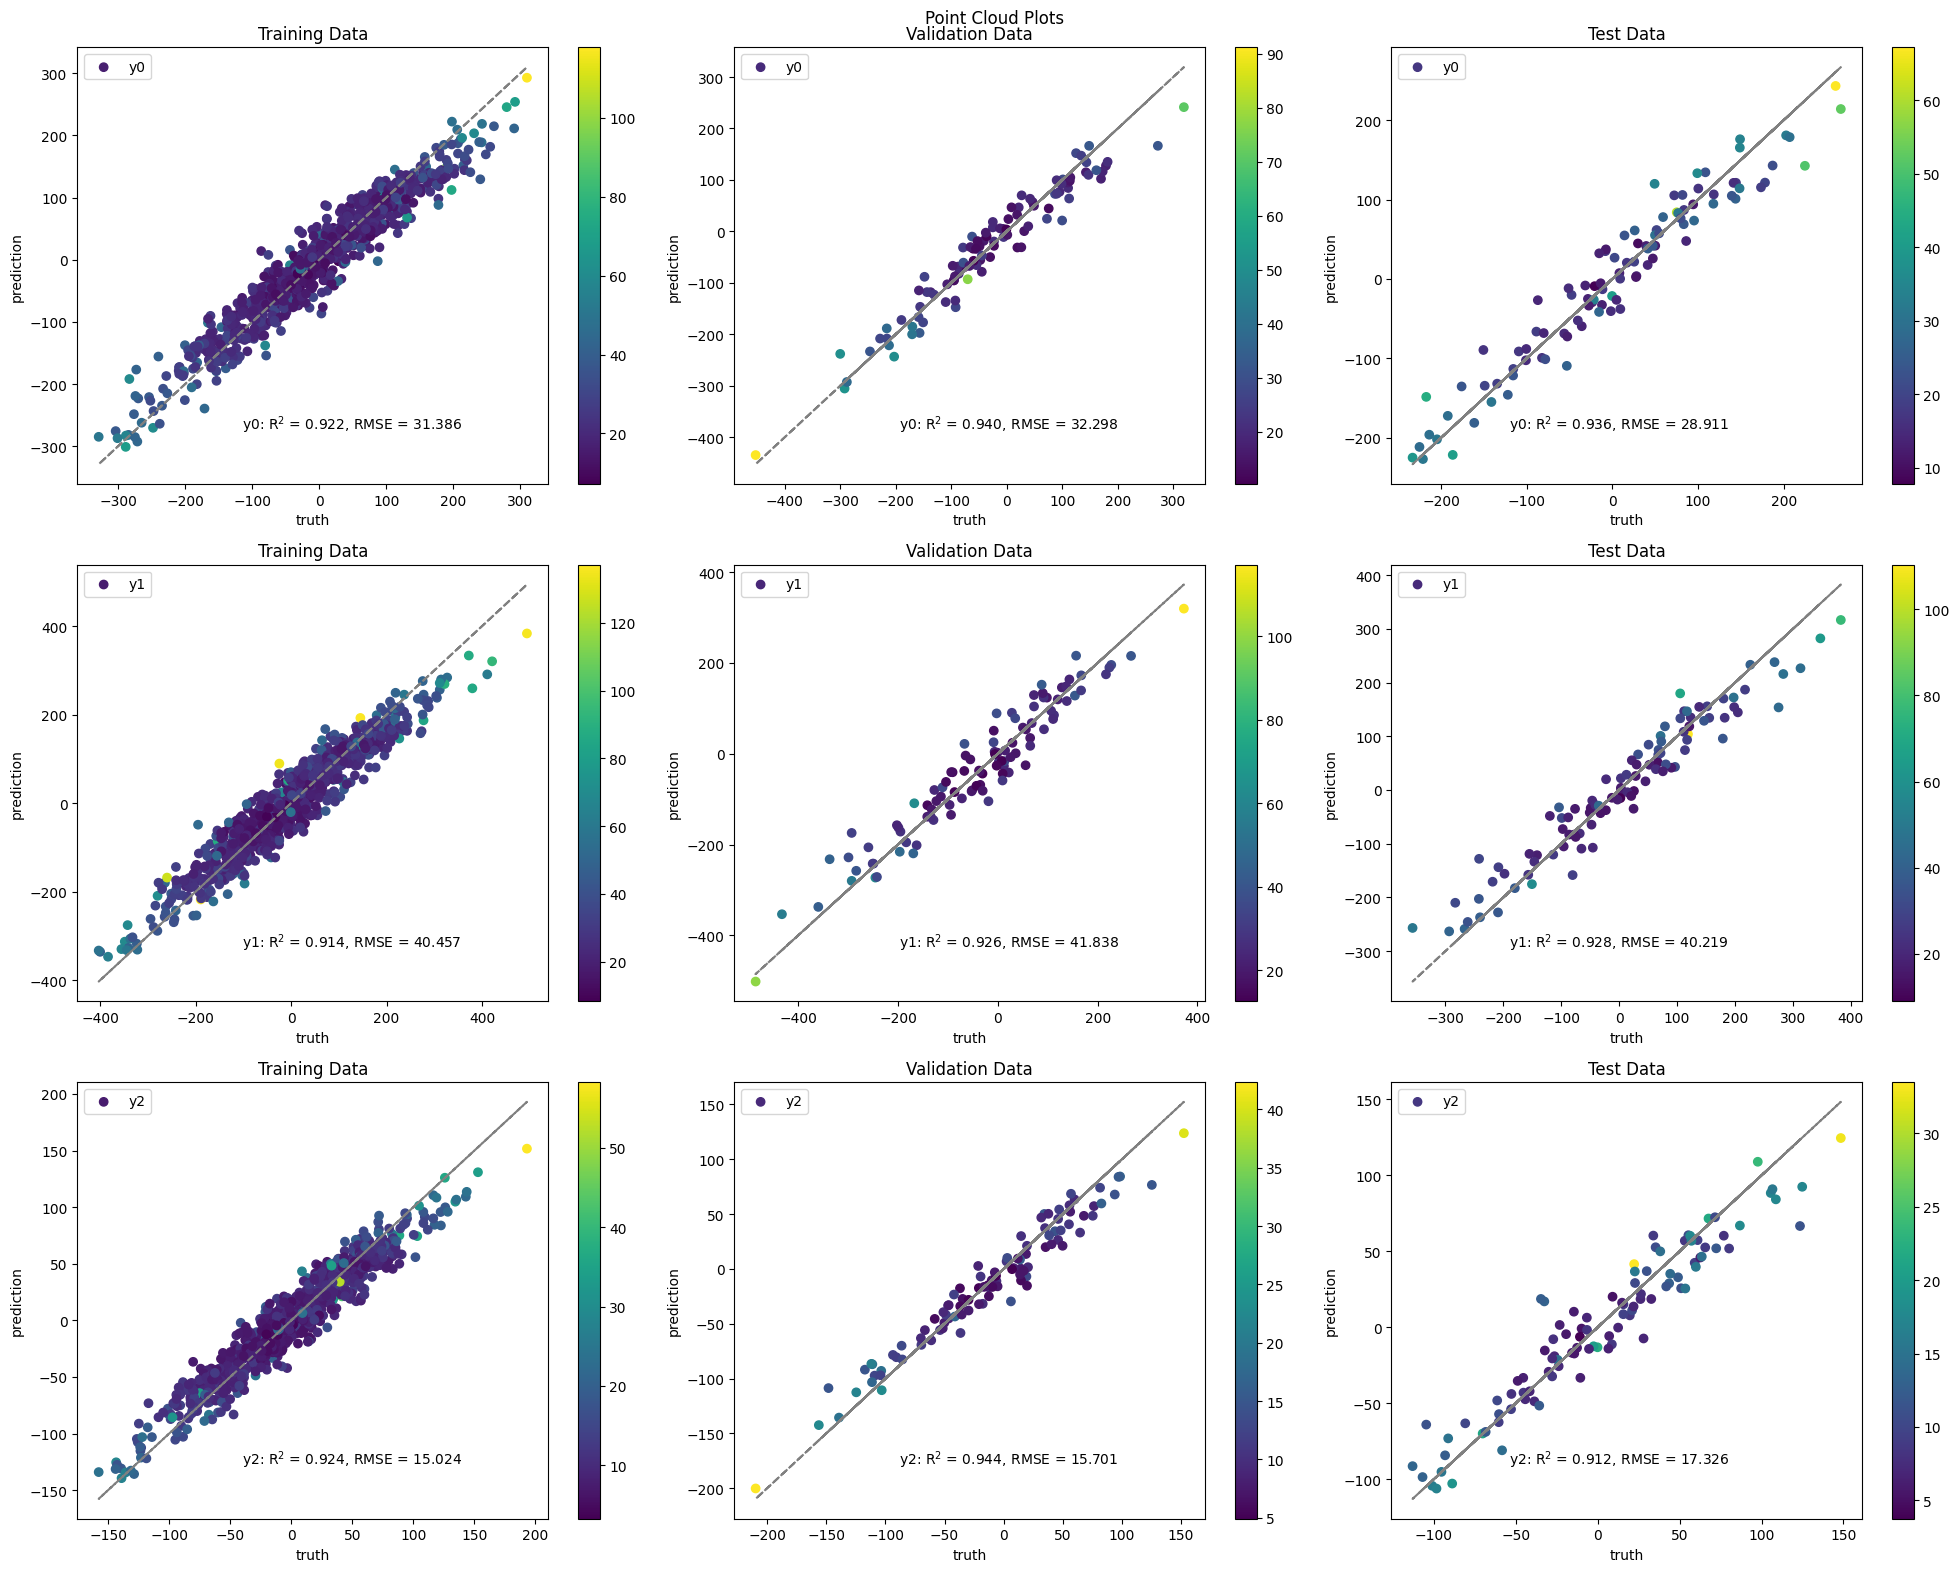

In [127]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/truth)**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_mean_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_mean_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_mean_test, y_test_real)

# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    # ax1.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}, RMSPE = {rmspe_train[i]:0.1%}", transform=ax1.transAxes)
    ax1.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_std_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Point Cloud Plots')
fig.tight_layout()
plt.show()

The RMSE in the predictions and the uncertainty values are much larger than either the ANN or the BLL. This is indicative of the more complex BNN model. Further resources must be devoted to training full BNN than BLL models. However, a full BNN will be more representative of the true epistemic uncertainty as it represents an ensemble model at each of the layers in the model.

Now, we can include the aleatoric uncertainty as well...

In [128]:
# Now, lets include the aleatoric uncertianty
do_aleatoric = True

model_bnn = BNN(
    width=width, 
    l1_norm=l1_norm, 
    l2_norm=l2_norm, 
    n_targets=n_targets, 
    n_samples=n_samples, 
    do_aleatoric=do_aleatoric,
)

model_bnn.compile(optimizer=Adam(learning_rate=learning_rate), loss=model_bnn.custom_loss)

# Print the model summary
model_bnn.build(input_shape=(n_samples, n_feats))
model_bnn.summary()

Model: "bnn_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_flipout_37 (DenseFlip  multiple                 210       
 out)                                                            
                                                                 
 dense_flipout_38 (DenseFlip  multiple                 210       
 out)                                                            
                                                                 
 dense_flipout_39 (DenseFlip  multiple                 210       
 out)                                                            
                                                                 
 dense_flipout_40 (DenseFlip  multiple                 0 (unused)
 out)                                                            
                                                                 
 dense_flipout_41 (DenseFlip  multiple                 126   

/home/nick/miniconda3/envs/mlmd/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/home/nick/miniconda3/envs/mlmd/lib/python3.11/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [129]:
# train the model
batch_size = 32
history = model_bnn.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=500,
    batch_size=batch_size,
    shuffle=True,
)

Epoch 1/500
25/25 [==============================] - 2s 18ms/step - loss: 43.9714 - val_loss: 58.5709
Epoch 2/500
25/25 [==============================] - 0s 5ms/step - loss: 40.4556 - val_loss: 52.8227
Epoch 3/500
25/25 [==============================] - 0s 4ms/step - loss: 35.4716 - val_loss: 43.9471
Epoch 4/500
25/25 [==============================] - 0s 4ms/step - loss: 27.5310 - val_loss: 31.1826
Epoch 5/500
25/25 [==============================] - 0s 4ms/step - loss: 17.0635 - val_loss: 17.2349
Epoch 6/500
25/25 [==============================] - 0s 4ms/step - loss: 9.0758 - val_loss: 8.9844
Epoch 7/500
25/25 [==============================] - 0s 4ms/step - loss: 5.0711 - val_loss: 5.1172
Epoch 8/500
25/25 [==============================] - 0s 4ms/step - loss: 3.1669 - val_loss: 3.2625
Epoch 9/500
25/25 [==============================] - 0s 4ms/step - loss: 2.2689 - val_loss: 2.3841
Epoch 10/500
25/25 [==============================] - 0s 4ms/step - loss: 1.7909 - val_loss: 2.034

The results should be analyzed in the same way that we did with the combined method for the BLL

In [130]:
# Evaluate the model performance on train and validation data using an ensemble of predictions with dropout enabled
num_preds = 100
pred_norm = np.stack([model_bnn(x_norm, training=False) for _ in range(num_preds)], axis=0)
pred_norm_train = np.stack([model_bnn(x_train, training=False) for _ in range(num_preds)], axis=0)
pred_norm_val = np.stack([model_bnn(x_val, training=False) for _ in range(num_preds)], axis=0)
pred_norm_test = np.stack([model_bnn(x_test, training=False) for _ in range(num_preds)], axis=0)

# We now have an ensemble of distributions from which we can extract the combined mean and standard deviations
# We will compute the prediction value as the mean of the ensemble of the distributions means
# We will compute the epistemic uncertainty as the standard deviation of the ensemble of the distributions means
# We will compute the aleatoric uncertainty as the mean of the ensemble of the distributions standard deviations
pred_mean_full = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm], axis=0).mean(axis=0)
pred_eu_full = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm], axis=0).std(axis=0)
pred_au_full = np.stack([y_normalizer.inverse_transform(y.stddev().numpy()) for y in pred_norm], axis=0).mean(axis=0)

pred_mean_train = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm_train], axis=0).mean(axis=0)
pred_eu_train = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm_train], axis=0).std(axis=0)
pred_au_train = np.stack([y_normalizer.inverse_transform(y.stddev().numpy()) for y in pred_norm_train], axis=0).mean(axis=0)

pred_mean_val = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm_val], axis=0).mean(axis=0)
pred_eu_val = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm_val], axis=0).std(axis=0)
pred_au_val = np.stack([y_normalizer.inverse_transform(y.stddev().numpy()) for y in pred_norm_val], axis=0).mean(axis=0)

pred_mean_test = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm_test], axis=0).mean(axis=0)
pred_eu_test = np.stack([y_normalizer.inverse_transform(y.mean().numpy()) for y in pred_norm_test], axis=0).std(axis=0)
pred_au_test = np.stack([y_normalizer.inverse_transform(y.stddev().numpy()) for y in pred_norm_test], axis=0).mean(axis=0)

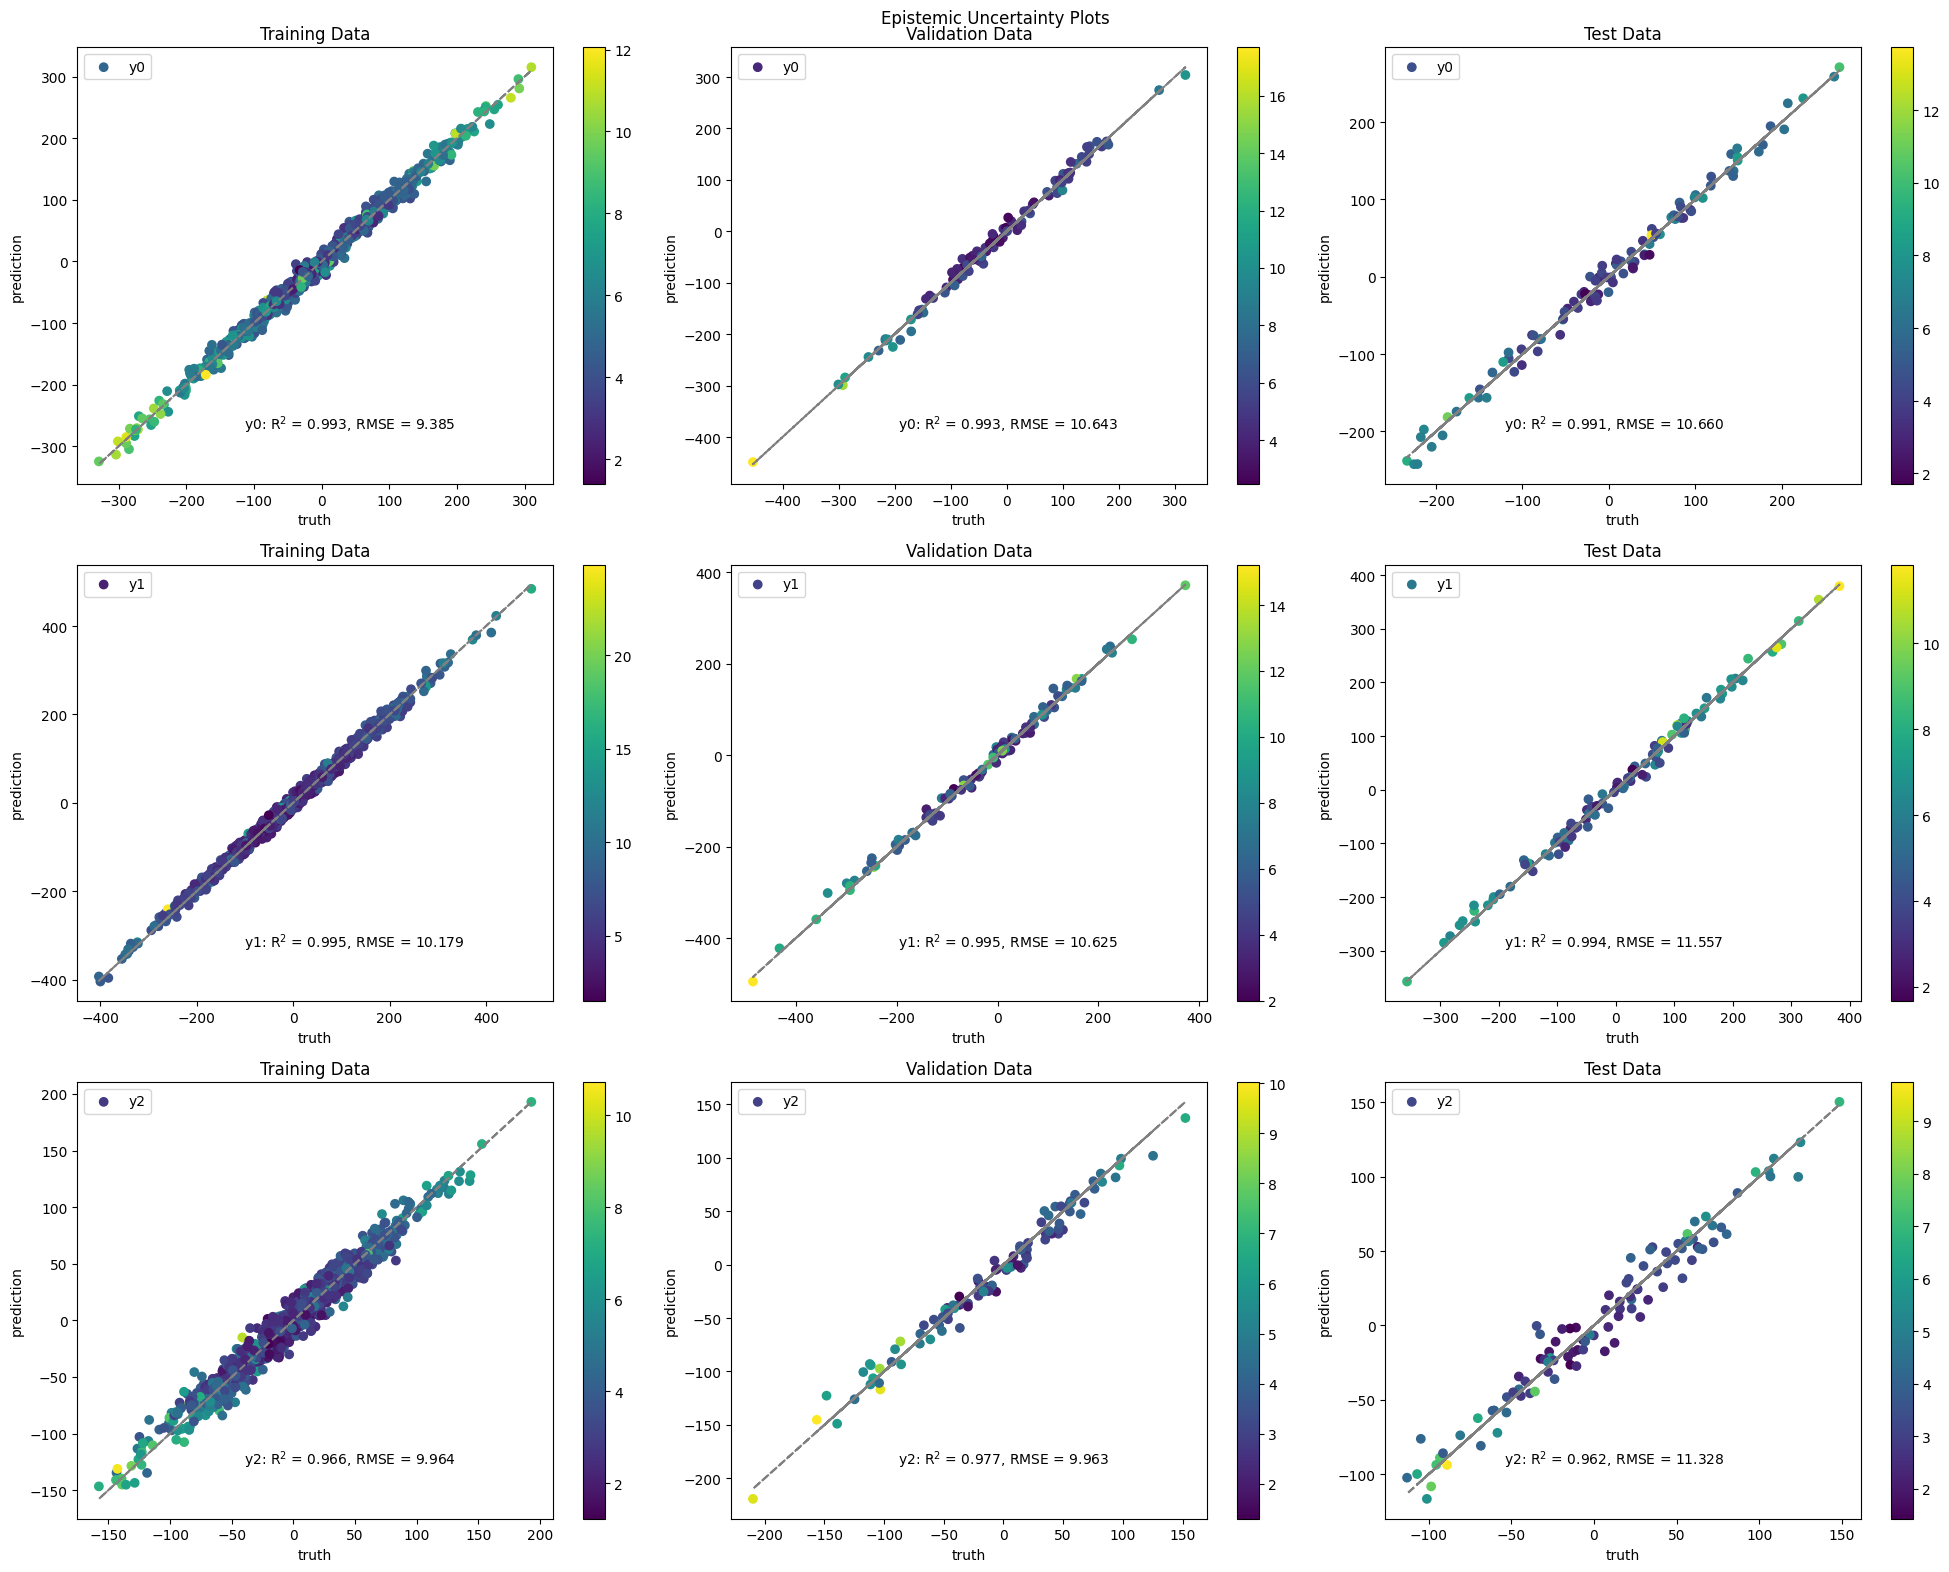

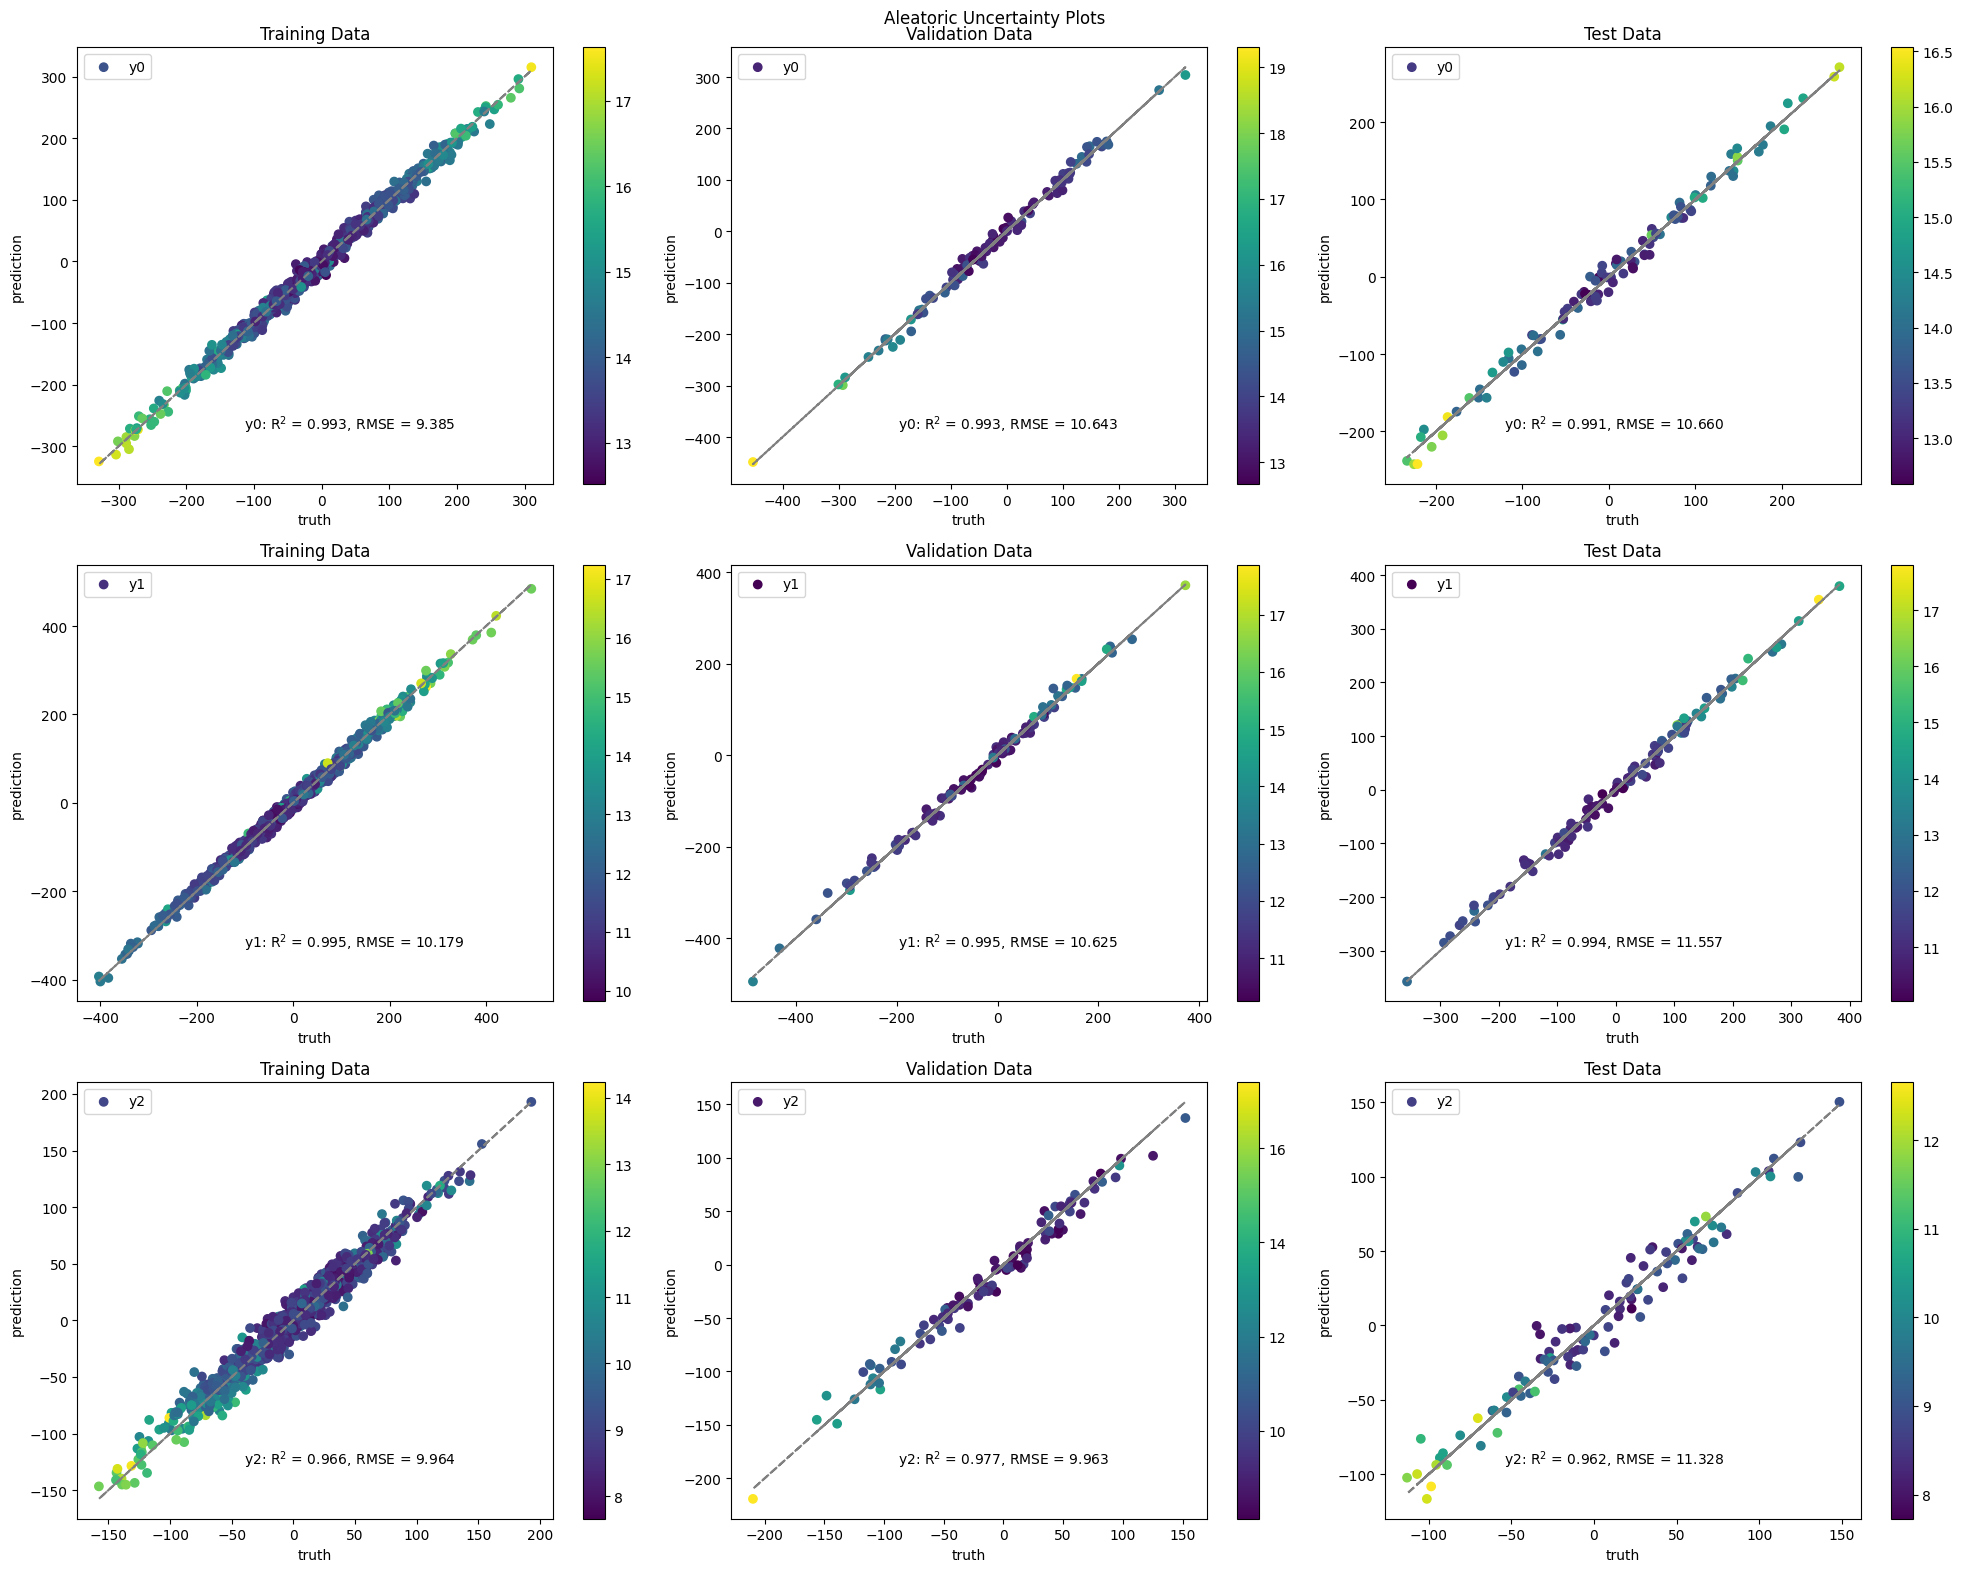

In [131]:
# Compute some statistics on the fit
from sklearn.metrics import mean_squared_error
def pred_stats(pred, truth):
    rss = np.sum((pred - truth) ** 2, axis=0)
    tss = np.sum((truth - np.mean(truth, axis=0)) ** 2, axis=0)
    r_sq = 1 - rss / tss
    rmse = np.sqrt(np.sum((truth-pred)**2, axis=0)/pred.shape[0])
    rmspe = np.sqrt(np.sum(((truth-pred)/truth)**2, axis=0)/pred.shape[0])
    return r_sq, rmse, rmspe
    
# Training data
r_sq_train, rmse_train, rmspe_train = pred_stats(pred_mean_train, y_train_real)
r_sq_val, rmse_val, rmspe_val = pred_stats(pred_mean_val, y_val_real)
r_sq_test, rmse_test, rmspe_test = pred_stats(pred_mean_test, y_test_real)


# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    ax1.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_eu_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Epistemic Uncertainty Plots')
fig.tight_layout()
plt.show()

# Visualize the predictions using a cloud plot
fig, axdict = plt.subplots(3, 3, figsize=(20, 16))
# Train plot
for i in range(n_targets):
    ax1 = axdict[i, 0]
    ax2 = axdict[i, 1]
    ax3 = axdict[i, 2]
    
    p1 = ax1.scatter(y_train_real[:, i], pred_mean_train[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_train[:, i])
    ax1.plot(y_train_real[:, i], y_train_real[:, i], linestyle="dashed", color="grey")
    ax1.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_train[i]:0.3f}, RMSE = {rmse_train[i]:0.3f}", transform=ax1.transAxes)
    ax1.legend()
    ax1.set_xlabel("truth")
    ax1.set_ylabel("prediction")
    ax1.set_title("Training Data")
    fig.colorbar(p1, ax=ax1)
    # Validation plot
    p2 = ax2.scatter(y_val_real[:, i], pred_mean_val[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_val[:, i])
    ax2.plot(y_val_real[:, i], y_val_real[:, i], linestyle="dashed", color="grey")
    # ax2.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}, RMSPE = {rmspe_val[i]:0.1%}", transform=ax2.transAxes)
    ax2.text(x=0.35, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_val[i]:0.3f}, RMSE = {rmse_val[i]:0.3f}", transform=ax2.transAxes)
    ax2.legend()
    ax2.set_xlabel("truth")
    ax2.set_ylabel("prediction")
    ax2.set_title("Validation Data")
    fig.colorbar(p2, ax=ax2)
    # Test plot
    p3 = ax3.scatter(y_test_real[:, i], pred_mean_test[:, i], marker="o", linestyle="None", label=f"y{i}", c=pred_au_test[:, i])
    ax3.plot(y_test_real[:, i], y_test_real[:, i], linestyle="dashed", color="grey")
    # ax3.text(x=0.25, y=0.2-0.075*i, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}, RMSPE = {rmspe_test[i]:0.1%}", transform=ax3.transAxes)
    ax3.text(x=0.25, y=0.2-0.075, s=rf"y{i}: R$^2$ = {r_sq_test[i]:0.3f}, RMSE = {rmse_test[i]:0.3f}", transform=ax3.transAxes)
    ax3.legend()
    ax3.set_xlabel("truth")
    ax3.set_ylabel("prediction")
    ax3.set_title("Test Data")
    fig.colorbar(p3, ax=ax3)

fig.suptitle('Aleatoric Uncertainty Plots')
fig.tight_layout()
plt.show()

### BNN Results
By confining our model predictions to a distribution we have better constrained the results of the full BNN and improved training stability. However, the results appear to be very similar to the BLL with combined uncertainty predictions which perhaps makes running the full BNN in aleatoric prediction mode overkill?

These results in this notebook are shown for a synthetic surrogate dataset and milage may vary when applied to a true scientific dataset.

# Conclusions
We have shown how one might quantify uncertainty in three different types of ML modes: ANNs, BLLs, and BNNs. Here we only consider results on a multidimentional regression task, but these principles can be applied to a variety of other ML tasks.